In [84]:
# import torch

In [85]:
# to form the table
import pandas as pd
import numpy as np

# To load and save files
import os
import glob
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import show 
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib import pylab
from pylab import *
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.widgets import TextBox

import seaborn as sns
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.io as sio
from PIL import Image




# set personal saving/ retrieving configuration


In [285]:
## Load new data set
load_new_neurons=0 # set to 1 to load, else retrieved
# define simulation is retrieved from (csv file)
location_simulation_file='/Volumes/Extreme_SSD/Projectome_finder/data/senn_single_pulse'
# Set subject and lead position
subject='MR012'
lead='GO2'

## Retrieving data/ location to save the data
location_data_dump=f'/Volumes/Extreme_SSD/Projectome_finder/CSV_and_pickle/{subject}/'
os.makedirs(location_data_dump,exist_ok=True)

## Plotting
save_plot=0 # set to 1 to automatically save all the plots
#define location where plots should be saved
# location_save_plots=f'Volumes/Extreme_SSD/Projectome_finder/plots/{subject}/'
location_save_plots=f'/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/{subject}/'
os.makedirs(location_save_plots,exist_ok=True)
#Define where images used in the plot are saved
location_image="/Volumes/Extreme_SSD/Projectome_finder/Images_for_plot"



# Neurons

## Save figure

In [87]:

def save_figure(folder_name, data_file):
    """
    A function to get the number for the heatmap by by taking the  electric current at the point where afferent recruitment reaches 100%.
    
    Parameters
    ----------
    folder_name
        which folder should it be saved to? eg. recruitment/roots
    data_file
        name of plot
    """
    data_folder = location_save_plots
    save_folder = os.path.join(data_folder,folder_name)
    os.makedirs(save_folder,exist_ok=True)
    data_file_path = os.path.join(save_folder,data_file)
    plt.savefig(data_file_path, transparent = "False",  
    facecolor='w'
            )
    print(f" figure saved: {data_file_path} ")

## Loading Neuron Simulation Results
Neuron simulations from monopolar electromagnetic (=EM) simulations. (No AF with threshold as it is done for multipolar configurations). 
Same approach as Rowald*, Komi*, Demesmaeker* et al. 2022.
Due to the fact that the code was poorly mantained and not transmited, this part of the pipeline needed to be coded again.

Author: Sergio Daniel Hernandez Charpak

December 2022

In [88]:
def combine_concatenate_two_string_arrays(array_1,array_2,n_arrays=2,sep_string="_"):
	"""
    Given two arrays of strings, it computes all the different combinations of
    arrays[item_array_1, item_array_2] and then form the array of the concatenation
    of these two times [item_array_1"sep"item_array_2].
    @returns array of strings [item_i_array_1"sep"item_j_array_2]
    """
	comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1,n_arrays)
	folders_to_iterate=[]
	for combination in comb_array:
		folder=""
		n_items_to_combine=len(combination)
		folder+=combination[0]
		for i in range(1,n_items_to_combine):
			folder+=(sep_string+combination[i])
		folders_to_iterate.append(folder)
	return folders_to_iterate

### Exploration
We explore one sim and one file to see how it is structred

In [89]:
if load_new_neurons:

    #get folder with simulations
    folder_raw_results=location_simulation_file
    #Each subfolder (for different lead placement)
    # contains the neuron simulation for each monopolar EM simulation.
    lead_pos=!ls $folder_raw_results
    print(lead_pos)
    electrodes=["E"+str(i).zfill(2) for i in range(16)]
    folder_raw_results_for_listing=os.path.join(folder_raw_results,'*')
    subfolder_list=glob.glob(folder_raw_results_for_listing)
    electrodes_from_listing=[folder_i[-3:] for folder_i in subfolder_list]
    n_monopolar_sims=len(electrodes_from_listing)

    # See how it is structured
    i_monopolar_sim=0
    monopolar_sim_i=electrodes_from_listing[i_monopolar_sim]
    monopolar_sim_sub_folder_i=subfolder_list[i_monopolar_sim]
    folder_files_monopolar_sim_sub_folder_i=os.path.join(monopolar_sim_sub_folder_i,'csv')
    folder_files_monopolar_sim_sub_folder_i_for_listing=os.path.join(folder_files_monopolar_sim_sub_folder_i,"*")
    files_monopolar_sim_sub_folder_i=glob.glob(folder_files_monopolar_sim_sub_folder_i_for_listing)
    n_total_fibers=len(files_monopolar_sim_sub_folder_i)
    i_fiber_sim=0
    file_fiber_i_sim=files_monopolar_sim_sub_folder_i[i_fiber_sim]
    df_fiber_i_sim=pd.read_csv(file_fiber_i_sim,sep=",")
    # All fibres per rootlet
    df_fiber_i_sim.head(50)
    df_fiber_i_sim.columns

We are mostly interested by the Tritration factor of each fiber. This is the key value to keep. For each tritration factor, fibers with a tritration factor smaller or equal to this value will count as active. For each factor we can then count the number of fibers active and the number of fibers inactive. These will be the values used to compute the recruitment percentages. 

In here each file contains the information for each rootlet (10 fibers per rootlet). 


We now have to :
* Get all this information in a dataframe. 
* Find the maximum overall tritration factor of the simulation (for each monopolar electrode)
* Find for each **Root** (not rootlet) the max tritration factor
* Do the counting of active fibers and inactive fibers
* Compute the recruitment

Found the method (implemented by Edoardo/Andreas):
```
Fiber_List = []
for root_idx, root_val in enumerate(Root_Name):
    for quad_idx,quad_val in enumerate(Quad_Name):
        for type_idx,type_val in enumerate(Type_Name):
            Fiber_List.append(root_val + '-' + quad_val + '_' + type_val)

for design in designs:
    for electrode in electrodes:

        filefolder = join(folderpath,design,electrode,'csv')
        titration_axes = [] # list holding titration factor from roots
        recruitment_percentage = [] # list holding recruitment percentage from roots
        for f_1 in Fiber_List:
            print f_1
            f = join(filefolder,'Titration_Sweeney - '+electrode+'_'+f_1+'.csv')
            titration_list = np.genfromtxt(join(filefolder,f), delimiter=',', skip_header=1)
            titration_list = titration_list[:,3] #remove later
            tdiv = np.linspace(np.min(titration_list), np.max(titration_list), datapoints) #number of data points
            rec=[]
            for t in tdiv:
                cn=0
                for tit in titration_list:
                    if tit<=t:
                        cn+=1
                rec.append(cn)
            rec=np.array(rec)
            percentage_rec = 100.*rec/n

            titration_axes.append(tdiv)
            recruitment_percentage.append(percentage_rec)
```

### Loading
Let us now load everything into one dataframe

In [90]:
if load_new_neurons:
    ## Define root names
    spinal_levels=["T12","L1","L2","L3","L4","L5","S1","S2","S3","S4"]
    quadrants=["DL","DR"]
    roots=combine_concatenate_two_string_arrays(spinal_levels,quadrants,n_arrays=2,sep_string="_")
    n_roots=len(roots)
    list_dfs_monopolar_sims=[]

    # Loop on the monopolar sims/electrodes
    for i_monopolar_sim in range(n_monopolar_sims):
        monopolar_sim_i=electrodes_from_listing[i_monopolar_sim]
        monopolar_sim_sub_folder_i=subfolder_list[i_monopolar_sim]
        folder_files_monopolar_sim_sub_folder_i=os.path.join(monopolar_sim_sub_folder_i,'csv')
        folder_files_monopolar_sim_sub_folder_i_for_listing=os.path.join(folder_files_monopolar_sim_sub_folder_i,"*")
        files_monopolar_sim_sub_folder_i=glob.glob(folder_files_monopolar_sim_sub_folder_i_for_listing)
        n_total_fibers=len(files_monopolar_sim_sub_folder_i)
        # Loop on the fibers from the file (fibers per rootlet)
        for i_fiber_sim in range(n_total_fibers):
            file_fiber_i_sim=files_monopolar_sim_sub_folder_i[i_fiber_sim]
            df_fiber_i_sim=pd.read_csv(file_fiber_i_sim,sep=",")
            # Find out which root it belongs to 
            # Gets a neuron name
            name_first_fiber_df_fiber_i_sim= df_fiber_i_sim['Neuron Name'][0]
            root_df_fiber_i=""
            for root_i in roots:
                if root_i in name_first_fiber_df_fiber_i_sim:
                    root_df_fiber_i=root_i
                    break
            df_fiber_i_sim['Root']=root_df_fiber_i
            spinal_level_df_fiber_i=""
            quadrant_df_fiber_i=""
            for spinal_level_i in spinal_levels:
                if spinal_level_i in root_df_fiber_i:
                    spinal_level_df_fiber_i=spinal_level_i
                    break
            df_fiber_i_sim['Spinal_Level']=spinal_level_df_fiber_i
            for quadrant_i in quadrants:
                if quadrant_i in root_df_fiber_i:
                    quadrant_df_fiber_i=quadrant_i
                    break
            df_fiber_i_sim['Quadrant']=quadrant_df_fiber_i
            df_fiber_i_sim['EM_Sim']=monopolar_sim_i
            list_dfs_monopolar_sims.append(df_fiber_i_sim)
    # Concat everything into one df
    df_neuron_sim=pd.concat(list_dfs_monopolar_sims,ignore_index=True)

    # Save the resulting dataframe
    file_name=f"Neuron_sim_{subject}_{lead}.csv"
    file_path=os.path.join(location_data_dump,file_name)
    os.makedirs(location_data_dump,exist_ok=True)
    df_neuron_sim.to_csv(file_path)

### Recruitment
Now we get the recruitmnet **per root** for each EM_Sim.

In [91]:
## Save recruitment values per combination  as dict and tensor ##
# dict because further processing with dict
# tensor if in future want to change all to one style
if load_new_neurons:
    # save a dict
    recruitment_simulation={}
    n_data_points=100 # Number of points which represents the "amplitude"
   
    ## create tensor
    #electrodes
    #roots
    #recruitment
    roots_recruitment_to_tensor=torch.ones(len(electrodes_from_listing),n_roots,100)
    print(roots_recruitment_to_tensor.size())

    ## Calculate recruitment ##
    # Loop through the monopolar EM simulations ( all the electrodes)
    for i_sim in range(n_monopolar_sims):
        sim_i=electrodes_from_listing[i_sim]
        # Get the results for this particular simulation (=particular electrode)
        df_neuron_sim_emSim_i=df_neuron_sim[df_neuron_sim['EM_Sim']==sim_i]
        # Get the min and max titration factors for this Neuron simulation
        min_trit_factor_sim_i=np.min(df_neuron_sim_emSim_i['Titration Factor'])
        max_trit_factor_sim_i=np.max(df_neuron_sim_emSim_i['Titration Factor'])
        
        # Form the array of titration factors
        trit_array_sim_i=np.linspace(min_trit_factor_sim_i,max_trit_factor_sim_i,n_data_points) # n_data_points=100
        # Loop through the simulated roots (all roots (L1 - T12))
        for i_root in range(n_roots):
            root_i=roots[i_root]
            # Get the results for this particular root for this particular simulation (5 rootlets for roots, 10 fibres per rootlet (=50 data points))
            df_neuron_sim_emSim_i_root_i=df_neuron_sim_emSim_i[df_neuron_sim_emSim_i['Root']==root_i] 
        
            ## Compute the recruitment
            # Only get the titration factor
            trit_factors_sim_i_root_i=df_neuron_sim_emSim_i_root_i['Titration Factor']
            # Prepare the results array
            recruitment_sim_i_root_i=np.zeros(np.shape(trit_array_sim_i)) 
            n_fibers_in_sim_i_root_i=len(trit_factors_sim_i_root_i) # 50, 5rootlets a 10 fibers

            # Loop through values of titration between the min and the max of the sim
            # activation can be 0 bc min value might be in a different root
            # min sim is equals no activation max sim equals max
            for i_trit in range(n_data_points): # Number of points which represents the "amplitude"
                trit_i=trit_array_sim_i[i_trit]
                # For a specific root, how many rootlets are activated at certain level (= titration factor) ?
                n_active_trit_i= (df_neuron_sim_emSim_i_root_i['Titration Factor'] <= trit_i).sum()
                # print(n_active_trit_i)
                recruitment_sim_i_root_i[i_trit]=n_active_trit_i
            recruitment_sim_i_root_i=recruitment_sim_i_root_i/n_fibers_in_sim_i_root_i

            # Prepare the output csv
            d_rec_emSim_i_root_i = {'Trit_Array': trit_array_sim_i, 'Recruitment': recruitment_sim_i_root_i}
            df_recruitment_emSim_i_root_i = pd.DataFrame(data=d_rec_emSim_i_root_i)
            df_recruitment_emSim_i_root_i['Root']=root_i
            df_recruitment_emSim_i_root_i['EM_Sim']=sim_i
            spinal_level_df_fiber_i=""
            quadrant_df_fiber_i=""
            for spinal_level_i in spinal_levels:
                if spinal_level_i in root_df_fiber_i:
                    spinal_level_df_fiber_i=spinal_level_i
                    break
            df_recruitment_emSim_i_root_i['Spinal_Level']=spinal_level_df_fiber_i
            for quadrant_i in quadrants:
                if quadrant_i in root_df_fiber_i:
                    quadrant_df_fiber_i=quadrant_i
                    break
            df_recruitment_emSim_i_root_i['Quadrant']=quadrant_df_fiber_i
            
            ## save in a tensor
            # electrode, root, reccruitment
            roots_recruitment_to_tensor[i_sim, i_root,:]=torch.tensor(df_recruitment_emSim_i_root_i['Recruitment'].values)

            ## Additional ways of saving ##
            # save create a class to save it as pickle file instead
            recruitment_simulation[f"_{electrodes_from_listing[i_sim]}_{roots[i_root]}"] = df_recruitment_emSim_i_root_i
        

    ## Dump files 
    #turn into df
    df_electrodes_for_roots= pd.DataFrame(electrodes_from_listing, columns =['electrode_name'])
    # save as csv
    df_electrodes_for_roots.to_csv(location_data_dump+'df_electrodes_for_roots.csv')
    # list version ; electrodes_from_listing
    
    #turn into df
    df_roots=pd.DataFrame(roots, columns =['root_name'])
    # save as csv                                       
    df_roots.to_csv(location_data_dump+'df_roots.csv')
    # list version ; roots

    # dump pickle file
    fh = open(location_data_dump+'recruitment_simulation_to_tensor'+'_'+subject+'.pkl', "wb")
    pickle.dump(roots_recruitment_to_tensor, fh)
    fh.close()
    fh = open(location_data_dump+'recruitment_simulation_as_dict'+'_'+subject+'.pkl', "wb")
    pickle.dump(recruitment_simulation, fh)
    fh.close()

## Retrieve pickle and csv data
If present data should be retrieved, set load_new_neurons to 0.

In [92]:
if load_new_neurons==0:



    with open(location_data_dump+'recruitment_simulation_to_tensor'+'_'+subject+'.pkl', 'rb') as handle:
        roots_recruitment_to_tensor = pickle.load(handle)
    with open(location_data_dump+'recruitment_simulation_as_dict'+'_'+subject+'.pkl', 'rb') as handle:
            recruitment_simulation = pickle.load(handle)

    df_electrodes_for_roots=pd.read_csv(location_data_dump+'df_electrodes_for_roots.csv')
    electrodes_from_listing=list(df_electrodes_for_roots["electrode_name"])
    df_roots=pd.read_csv(location_data_dump+'df_roots.csv')
    roots=list(df_roots["root_name"])
    # electrodes=list(electrodes_from_listing)



In [93]:
# separate left and right
roots_left=['T12_DL','L1_DL','L2_DL','L3_DL','L4_DL','L5_DL','S1_DL','S2_DL','S3_DL','S4_DL']
roots_right=['T12_DR','L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR','S3_DR','S4_DR']

## Plot the simulations (recruitment curve)

In [94]:

def get_recruitment_curve_per_electrode(save_fig=save_plot,recruitment_simulation=recruitment_simulation, electrodes_from_listing=electrodes_from_listing, roots_left=roots_left, roots_right=roots_right):
    """
    A function to create recruitment curves by electrode

    Parameters
    ----------
    
    save_fig
        int, set to 1 to save figure
    recruitment_simulation
        dict with recruitment per electrode root combination,set by default
    electrodes_from_listing
        list, all ellectrodes used in data, set by default
    roots_left, roots_right
        list, all roots used in data, separated left and right, set by default


    """

    legend_title= "spinal roots"
    xLabel="Electric current [a.u]"
    yLabel="Afferent recruitment [%]"

    x=np.arange(0, 100)
    # Left activation
    for electrode in range (len(electrodes_from_listing)):
        plt.figure(figsize=(10, 10))
        plt.title(f"Left root activation for {electrodes_from_listing[electrode]} ")
        for root in roots_left:
            
            plt.plot(x,recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"], label=root)
            plt.legend(title=legend_title)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)

            if save_fig:
                print("figure is saved")
                data_file = electrodes_from_listing[electrode]+"_"+"recruitment_curve"+'.png'
                save_figure(folder_name="Recruitment_curve/roots", data_file=data_file)
            
        plt.show()

    # Right activation
    for electrode in range (len(electrodes_from_listing)):
        plt.figure(figsize=(10, 10))
        plt.title(f"Right root activation for {electrodes_from_listing[electrode]} ")
        for root in roots_right:
            
            plt.plot(x,recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"], label=root)
            plt.legend(title=legend_title)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)
            if save_fig:
                data_file = electrodes_from_listing[electrode]+"_"+"recruitment_curve"+'.png'
                save_figure(folder_name="Recruitment_curve/roots", data_file=data_file)
        plt.show()

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
figure is saved


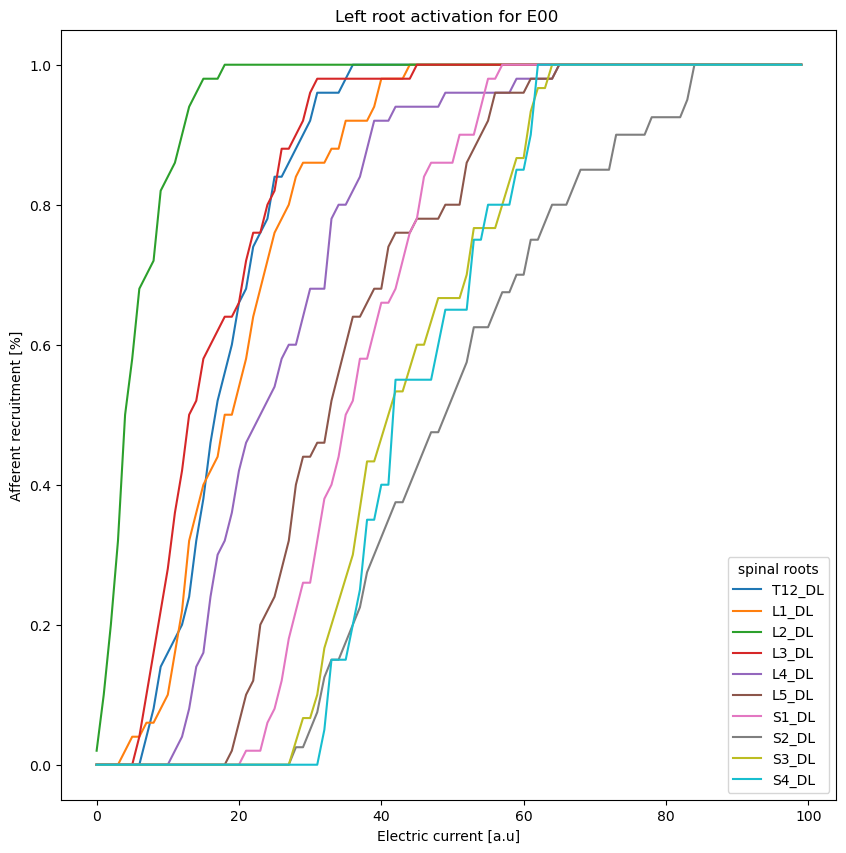

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
figure is saved


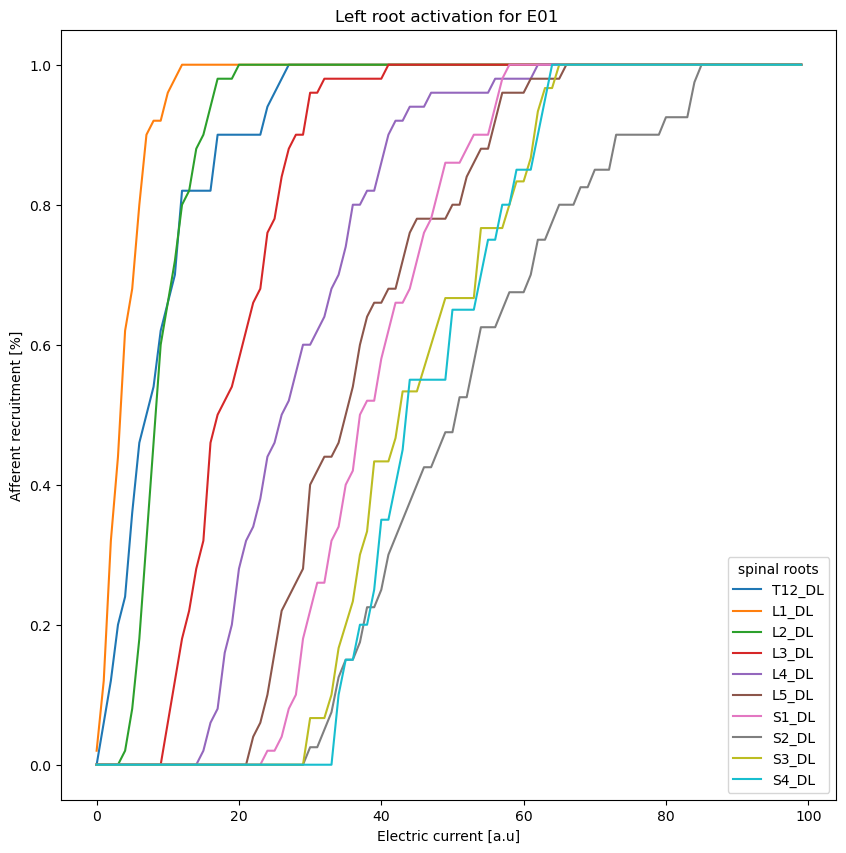

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
figure is saved


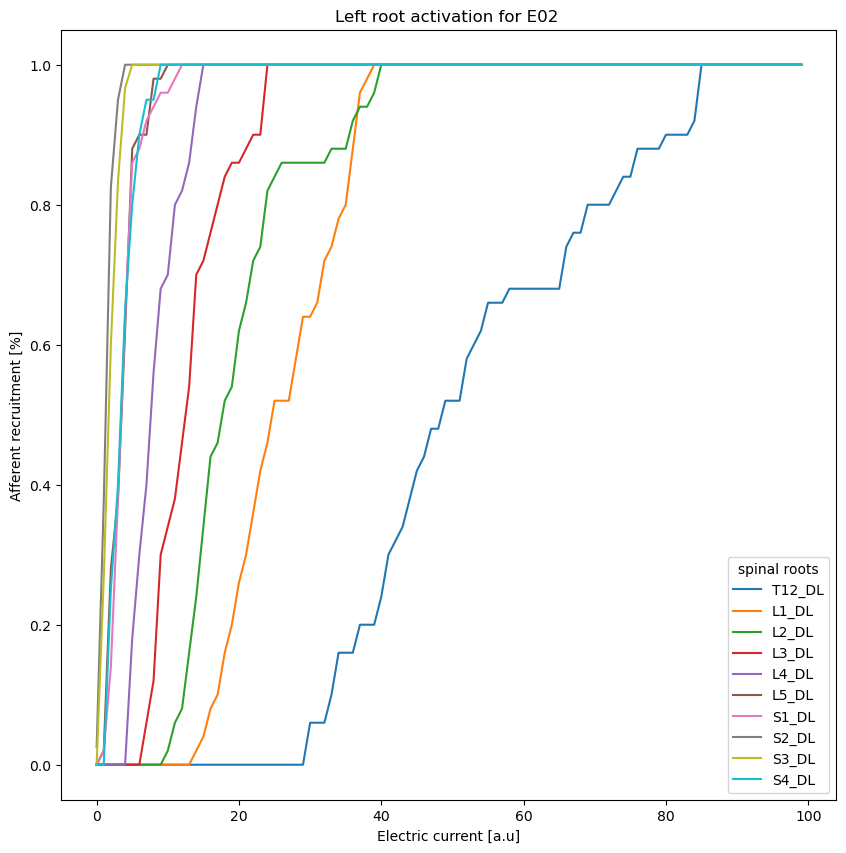

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
figure is saved


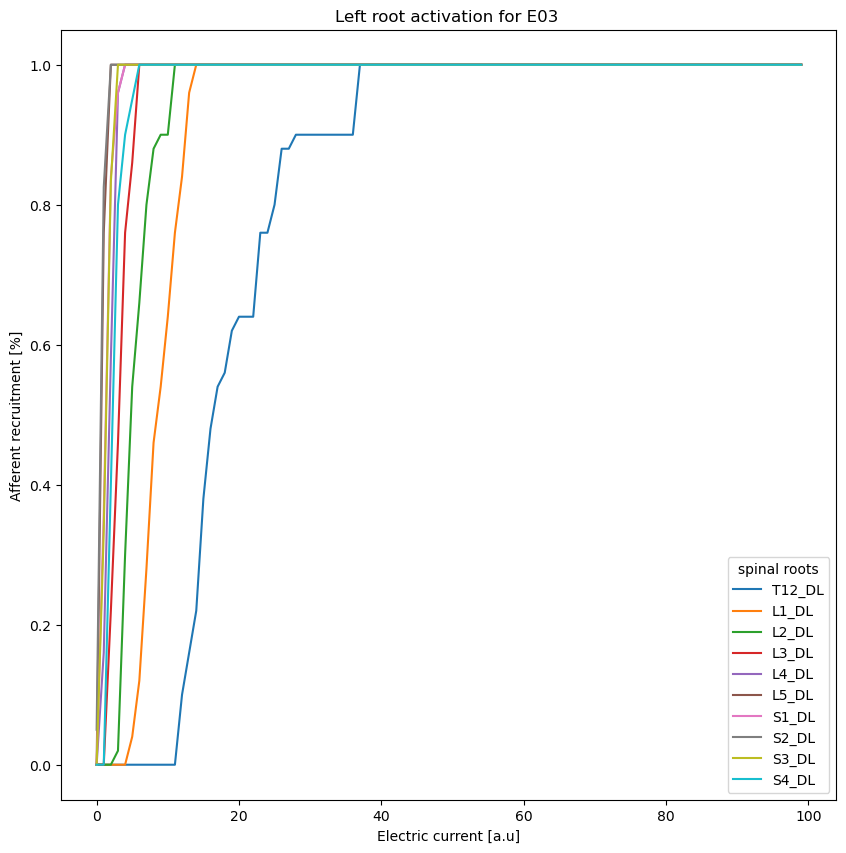

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
figure is saved


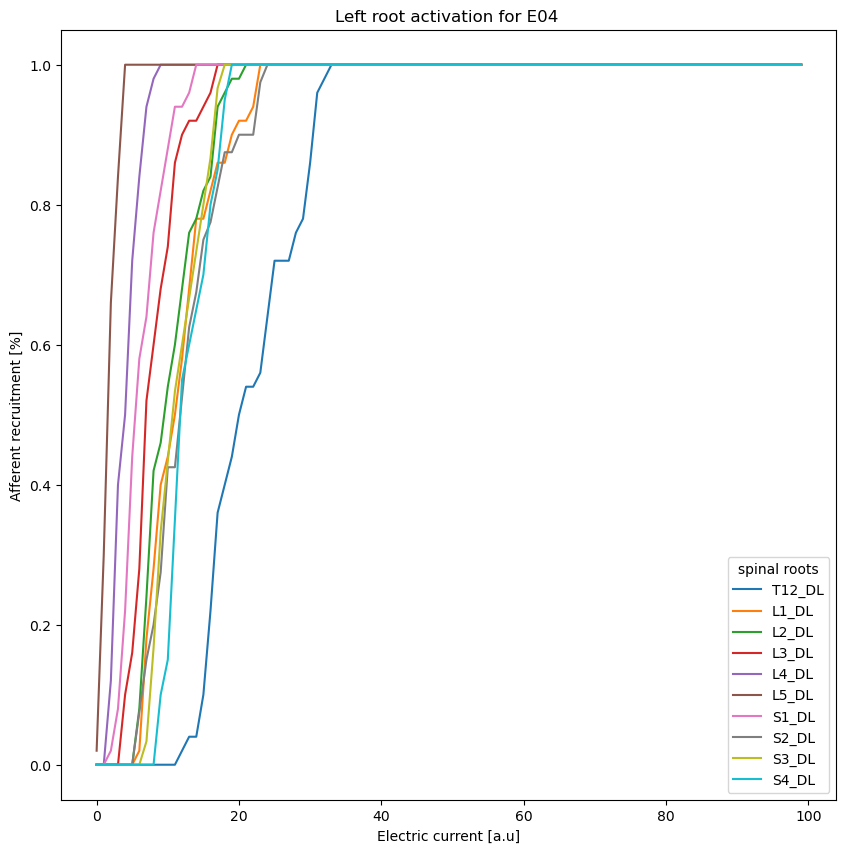

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
figure is saved


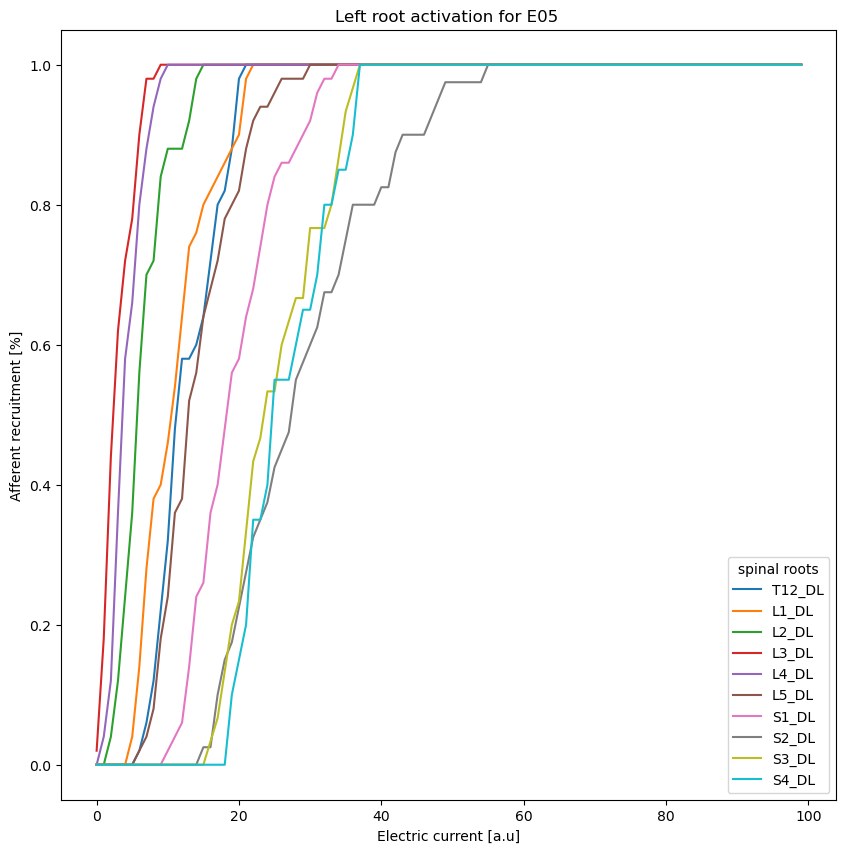

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
figure is saved


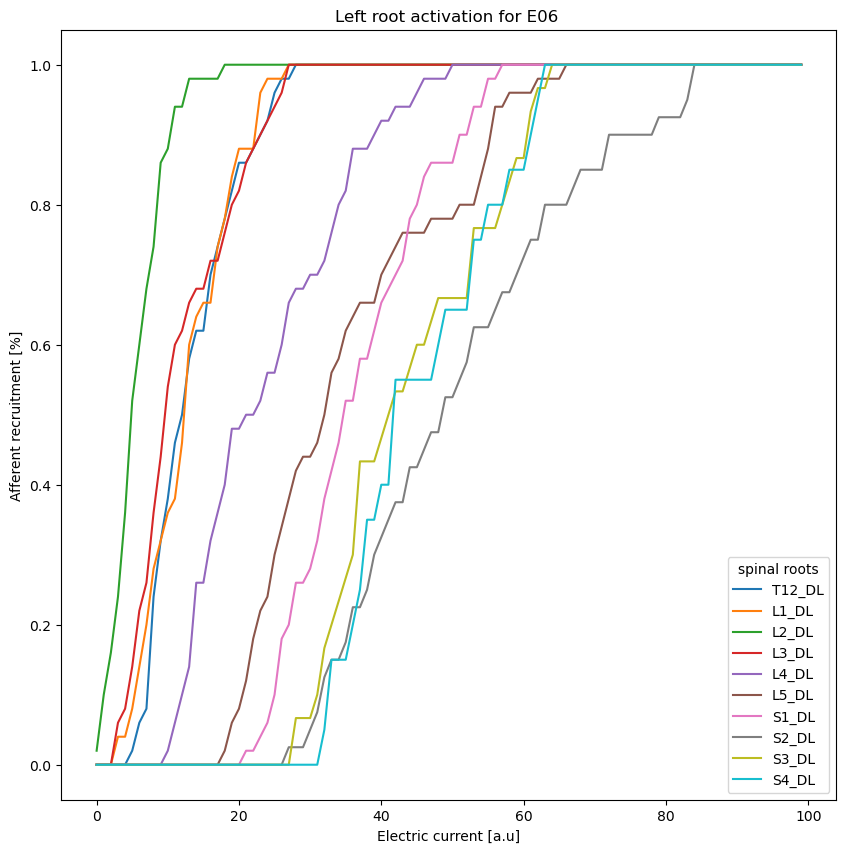

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
figure is saved


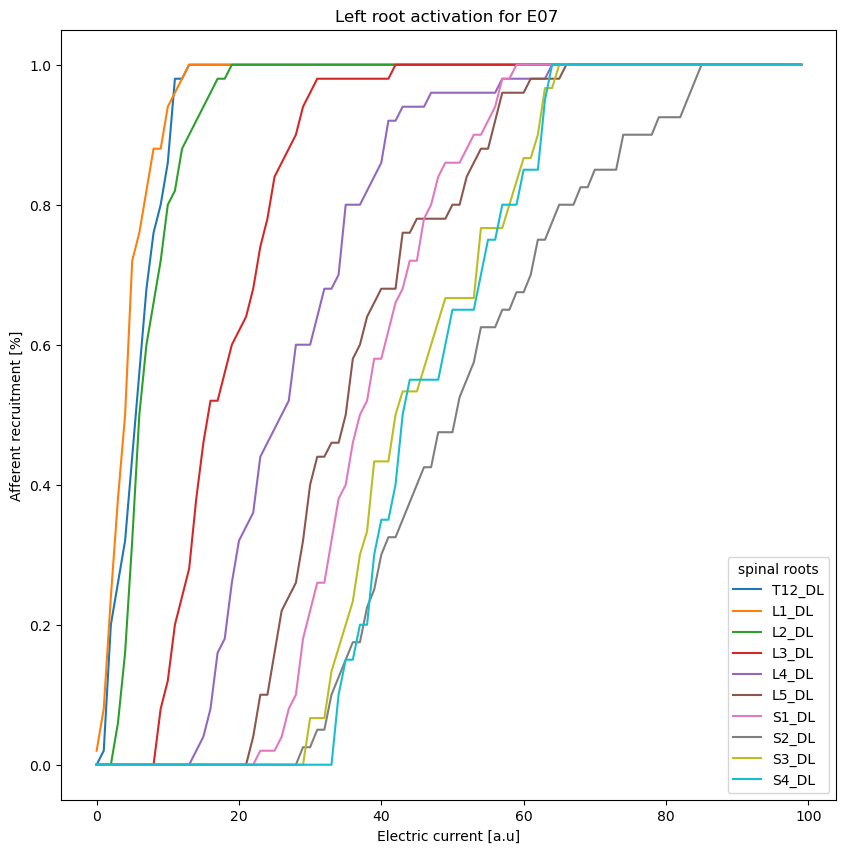

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
figure is saved


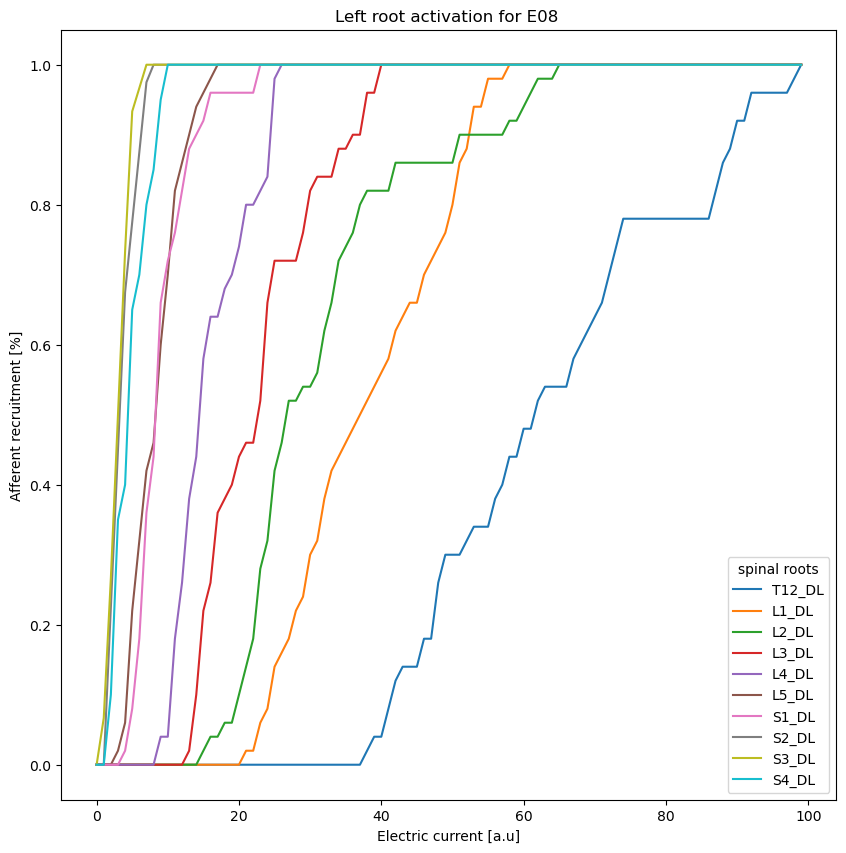

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
figure is saved


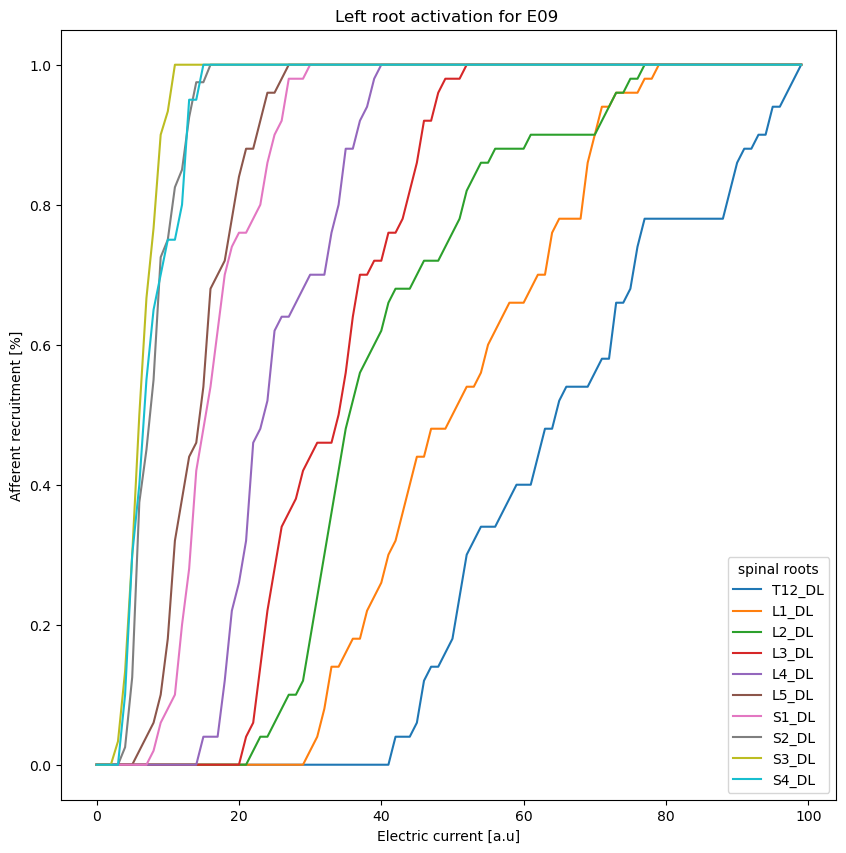

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
figure is saved


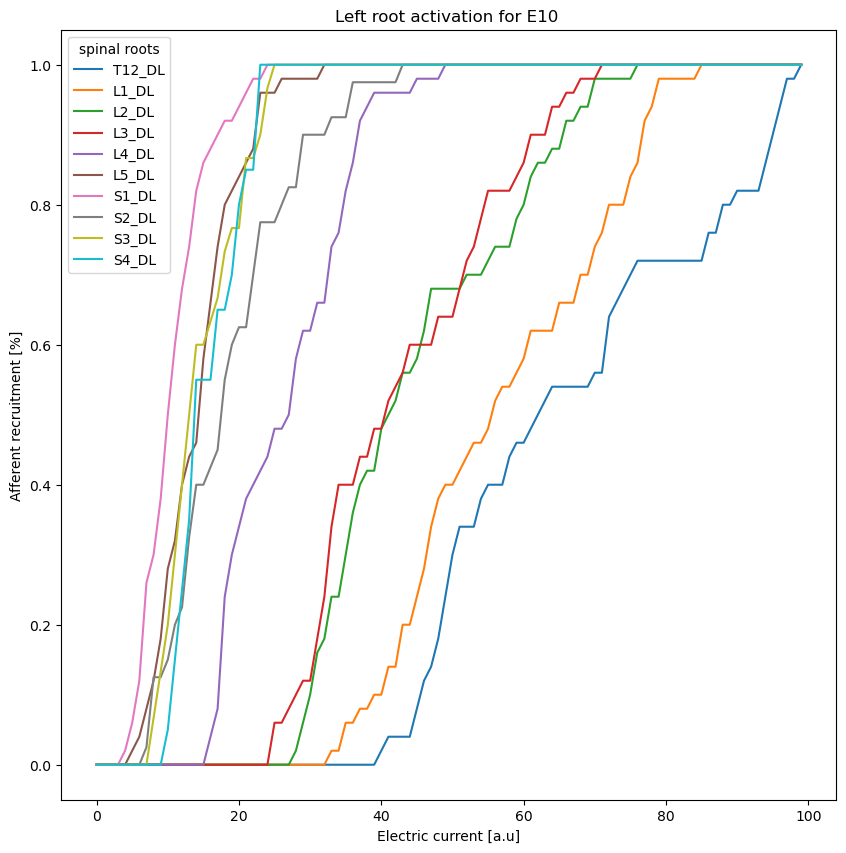

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
figure is saved


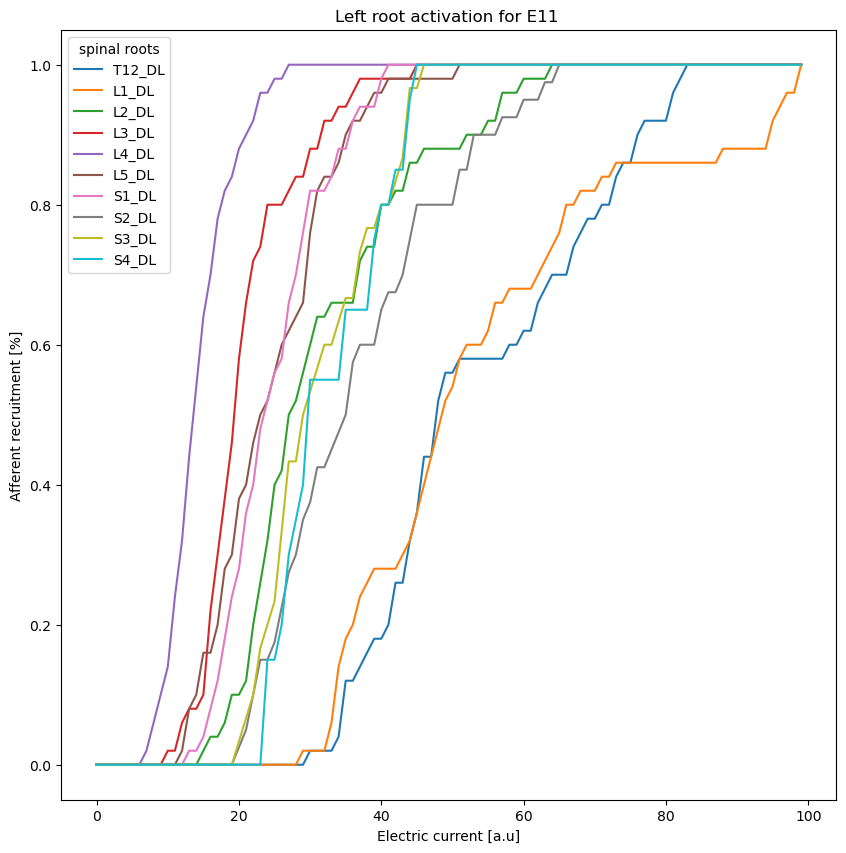

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
figure is saved


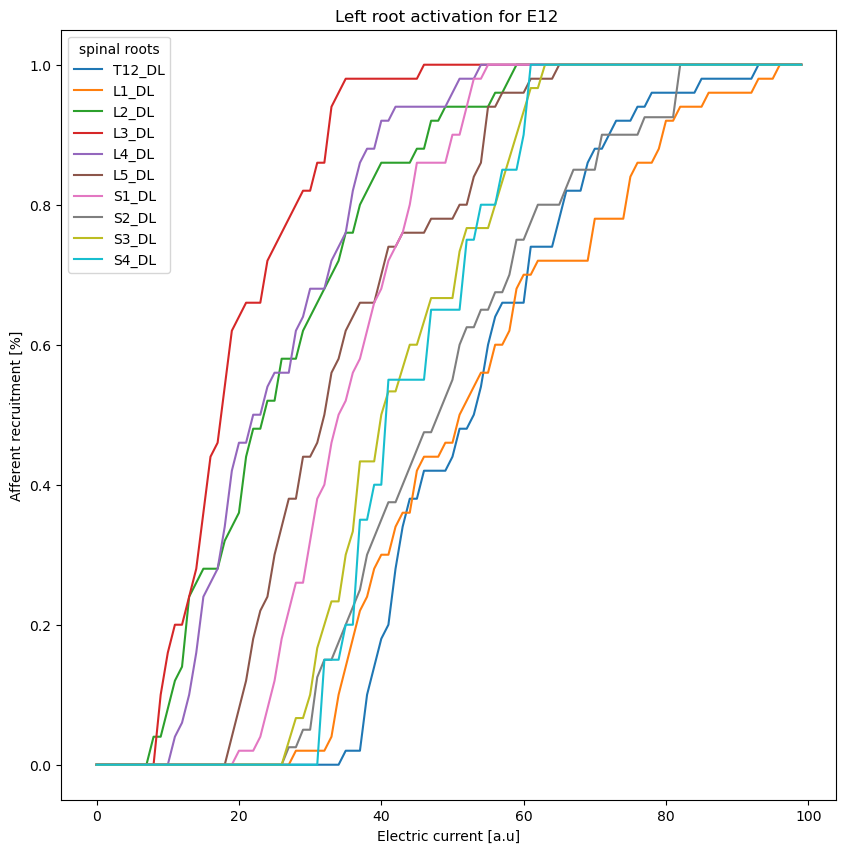

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
figure is saved


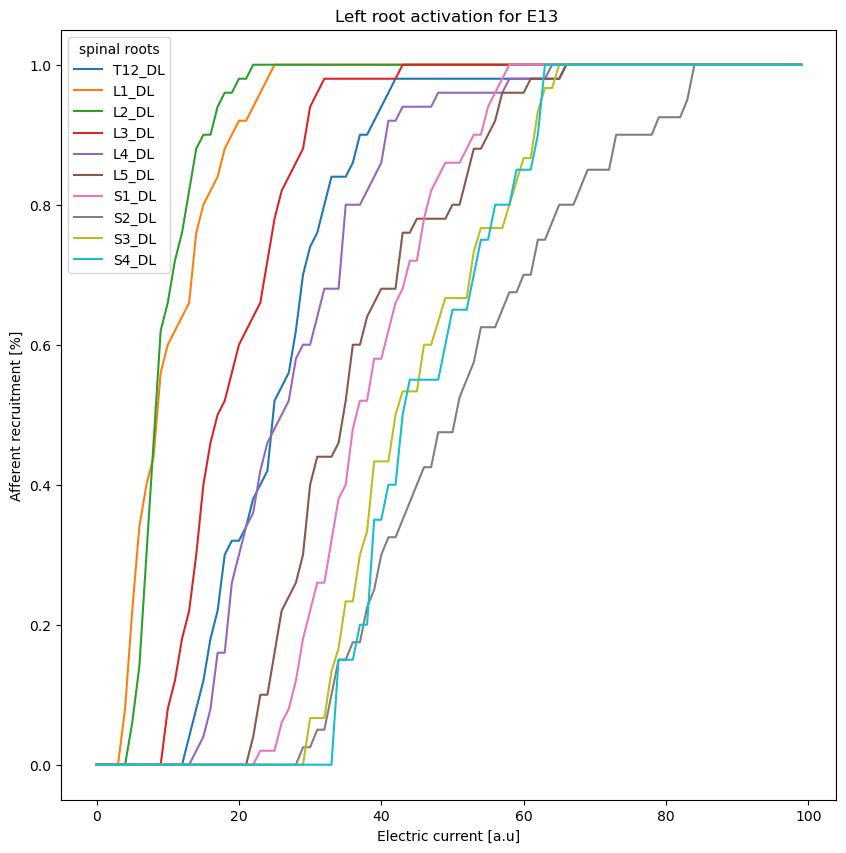

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
figure is saved


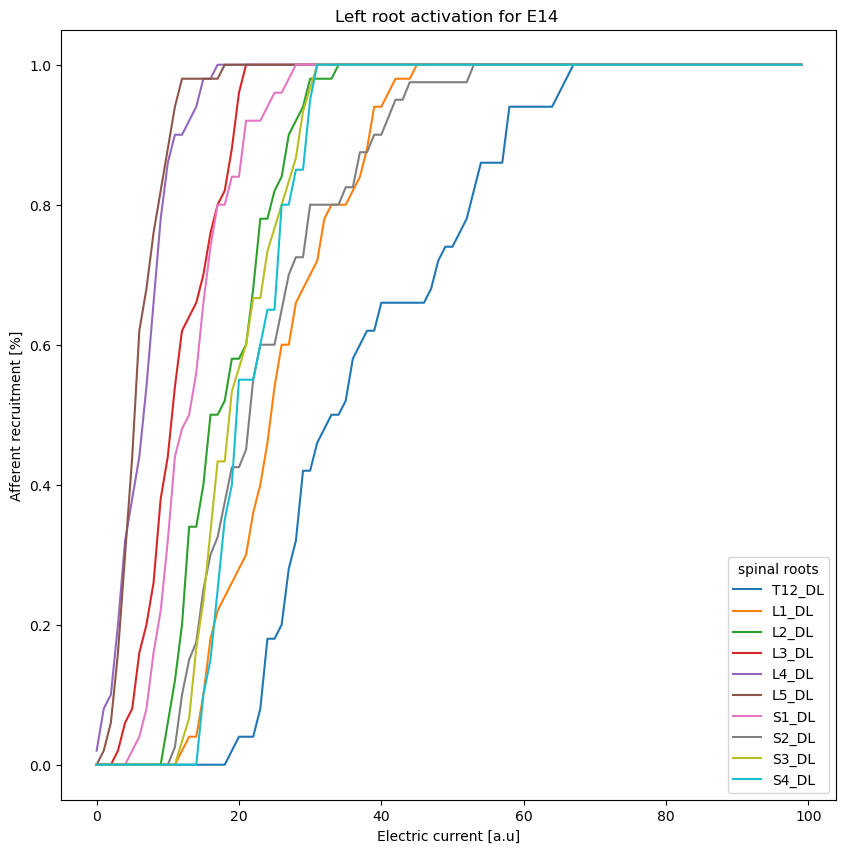

figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
figure is saved
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
figure is saved


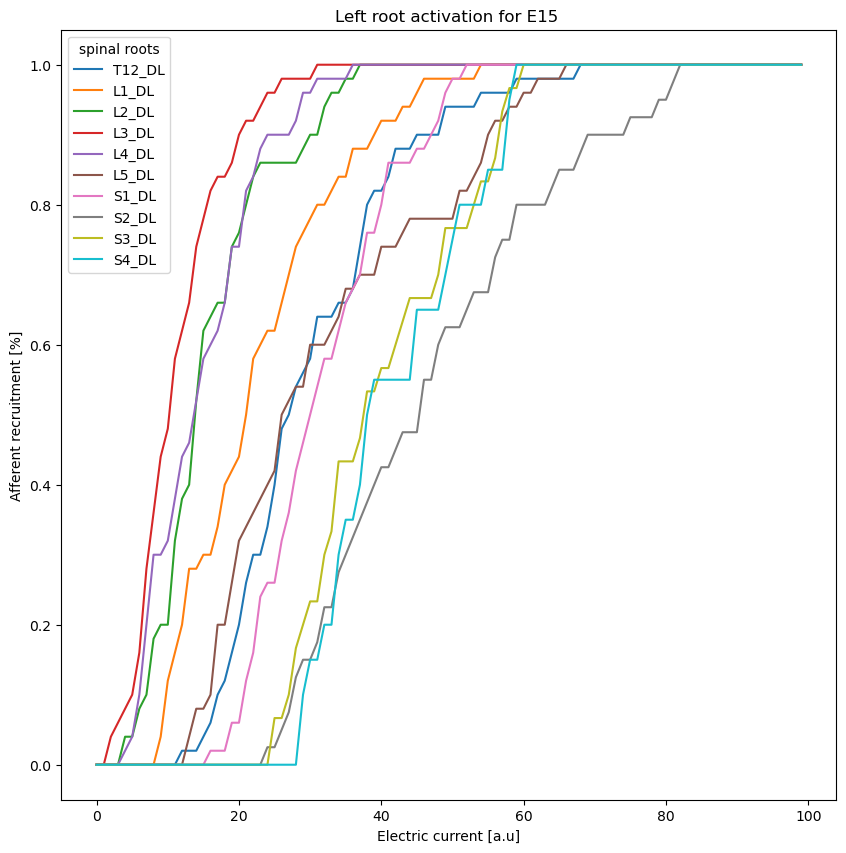

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E00_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

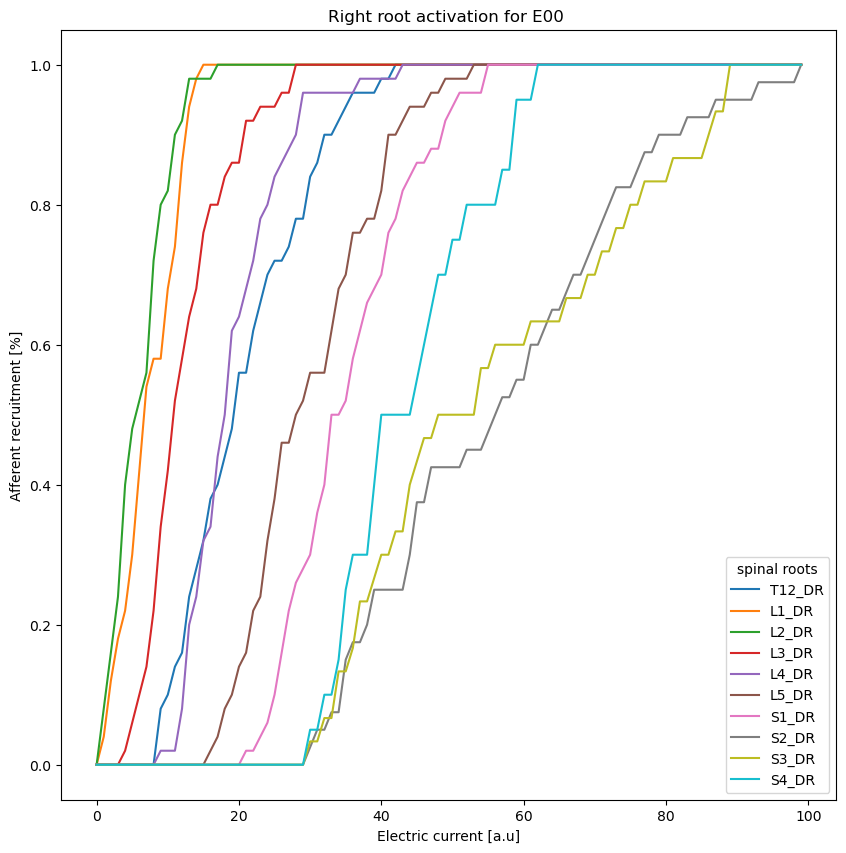

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E01_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

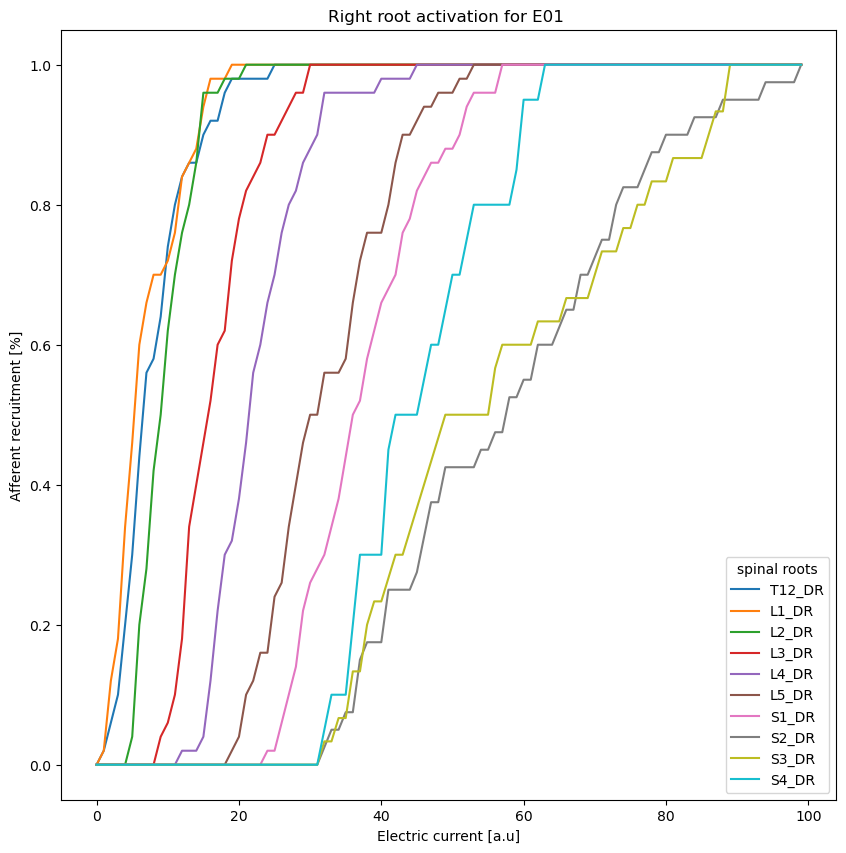

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E02_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

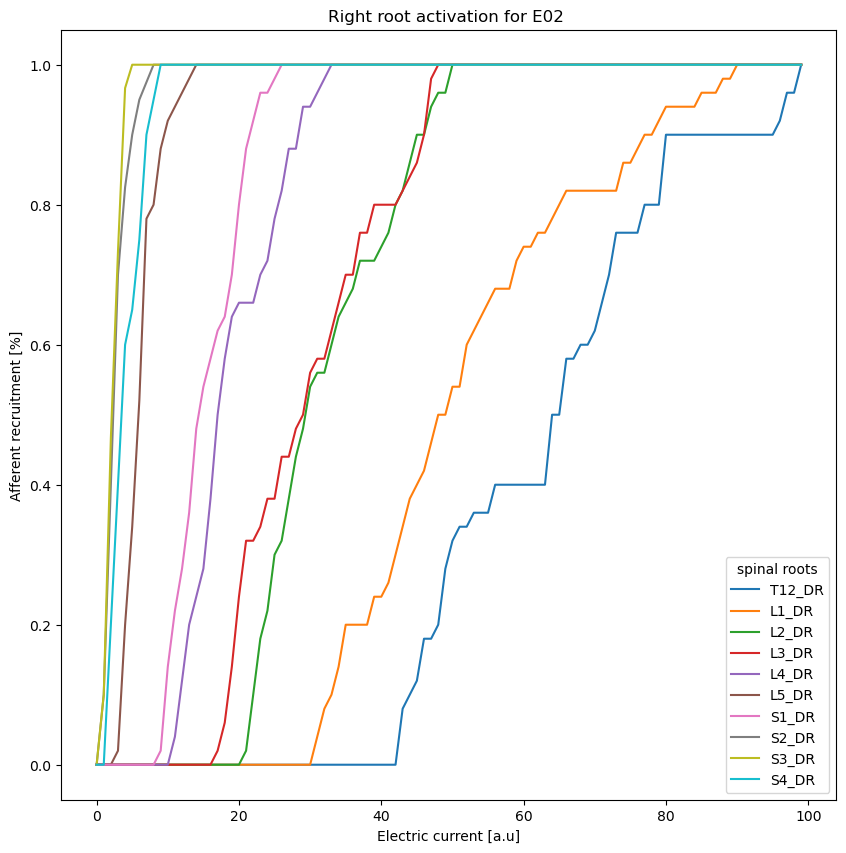

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E03_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

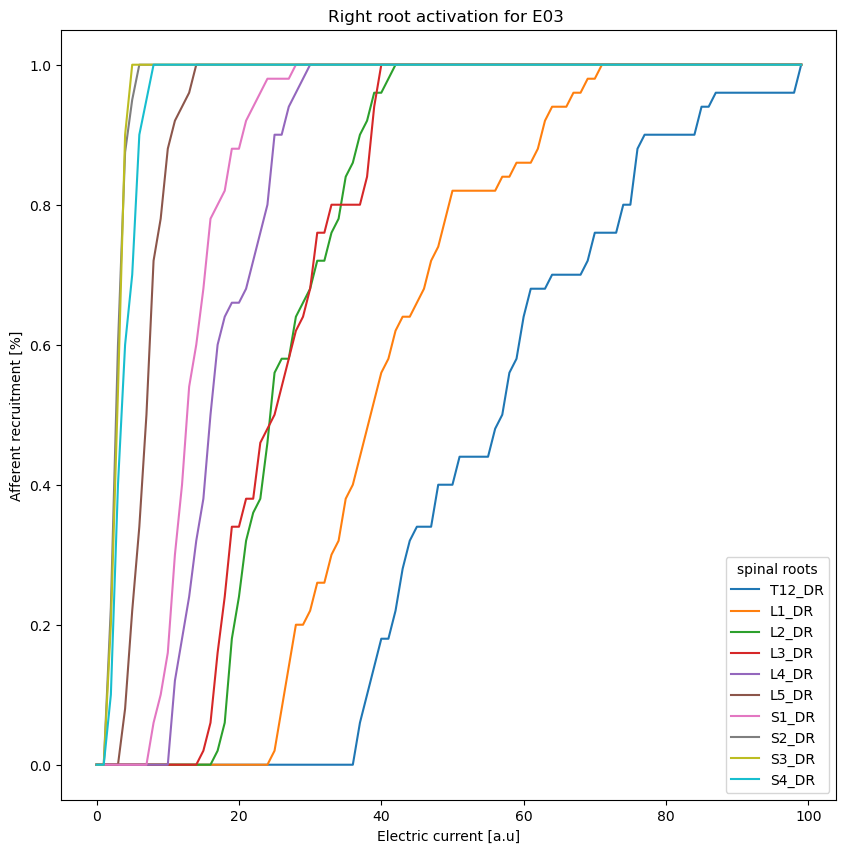

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E04_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

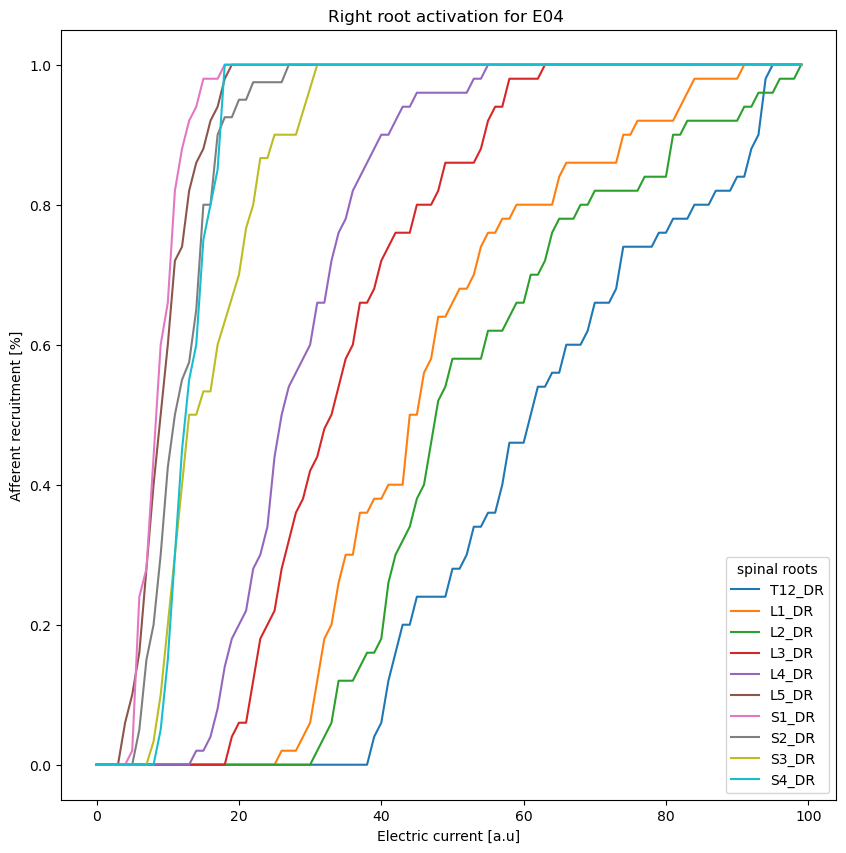

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E05_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

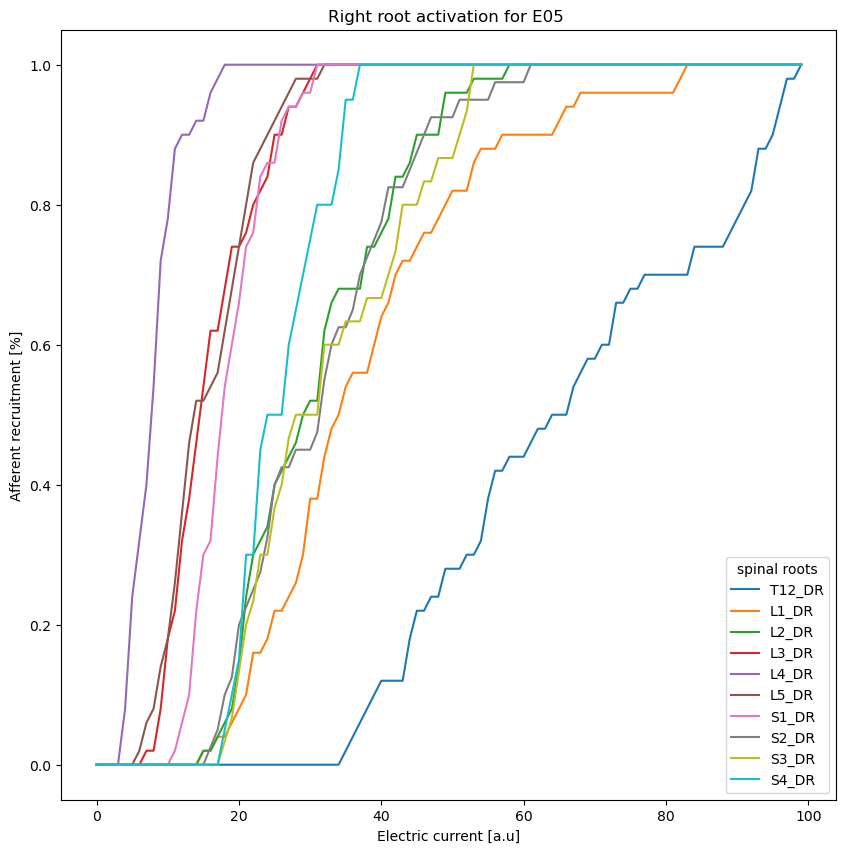

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E06_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

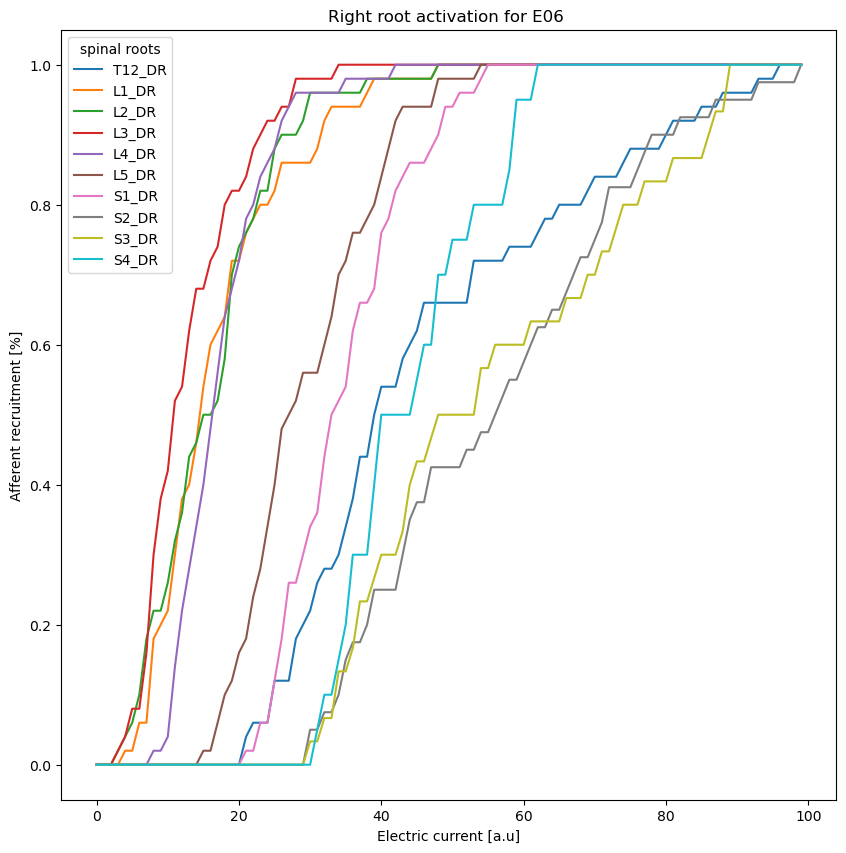

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E07_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

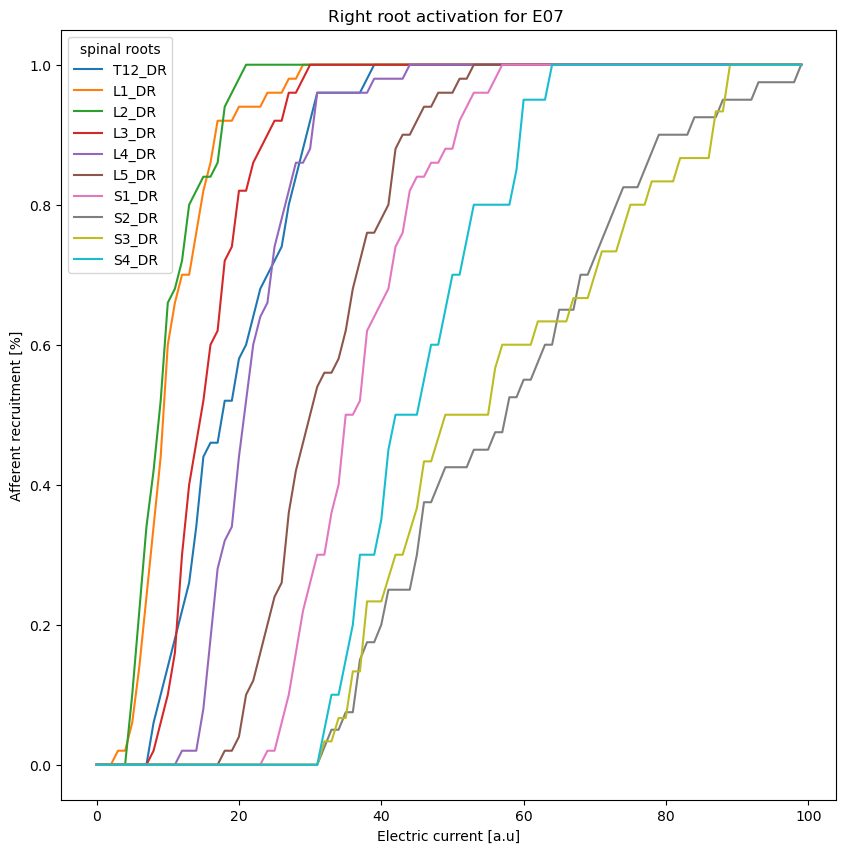

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E08_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

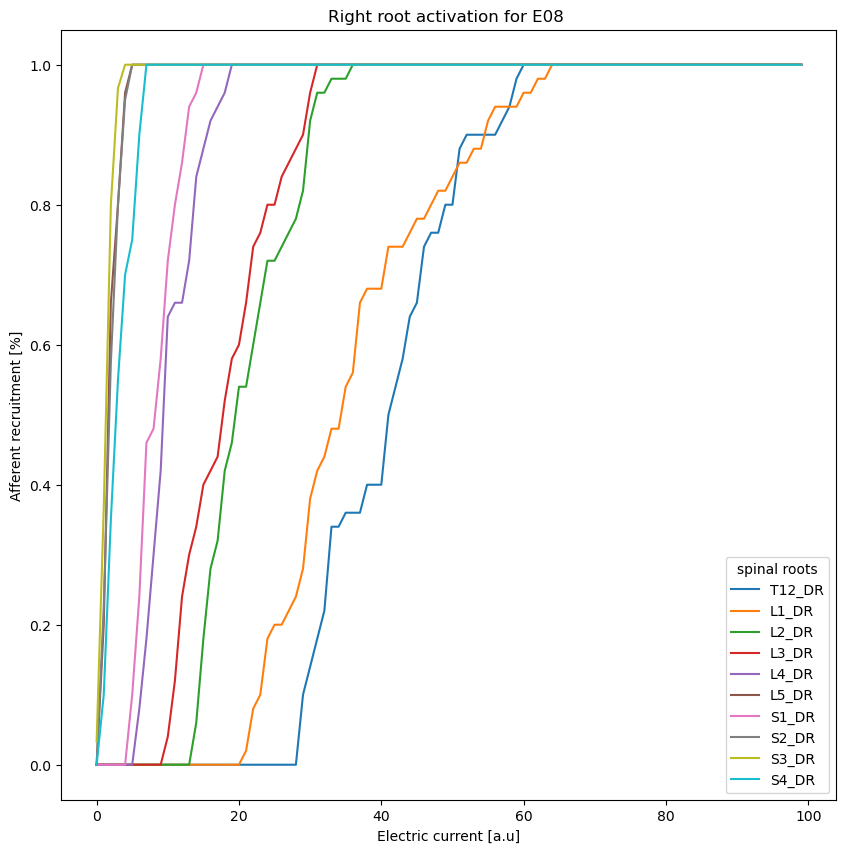

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E09_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

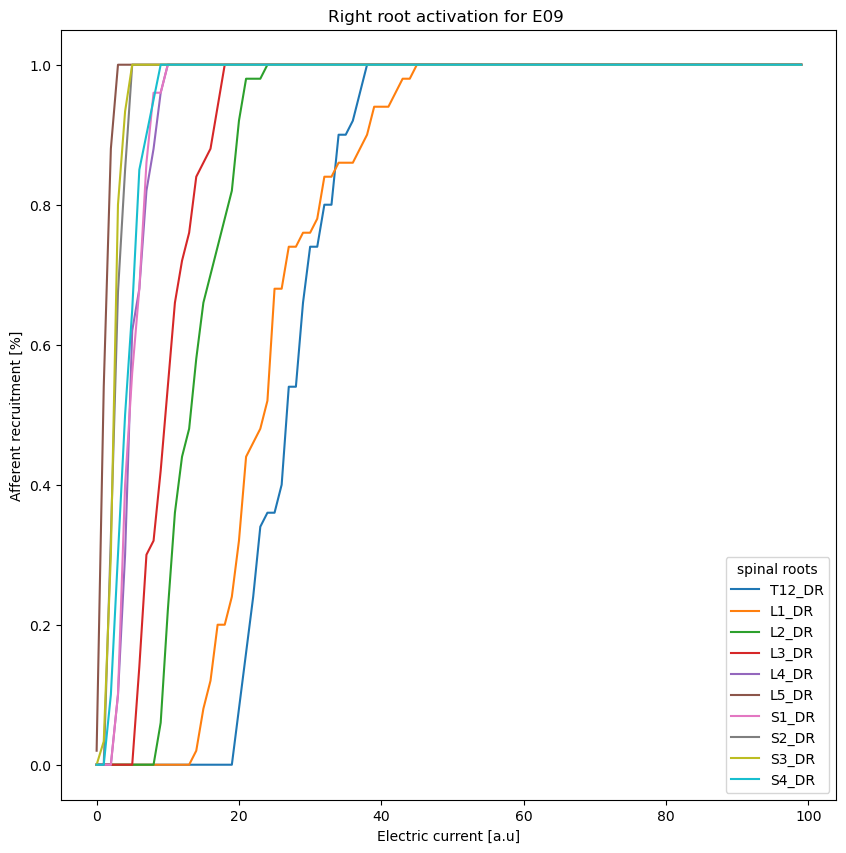

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E10_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

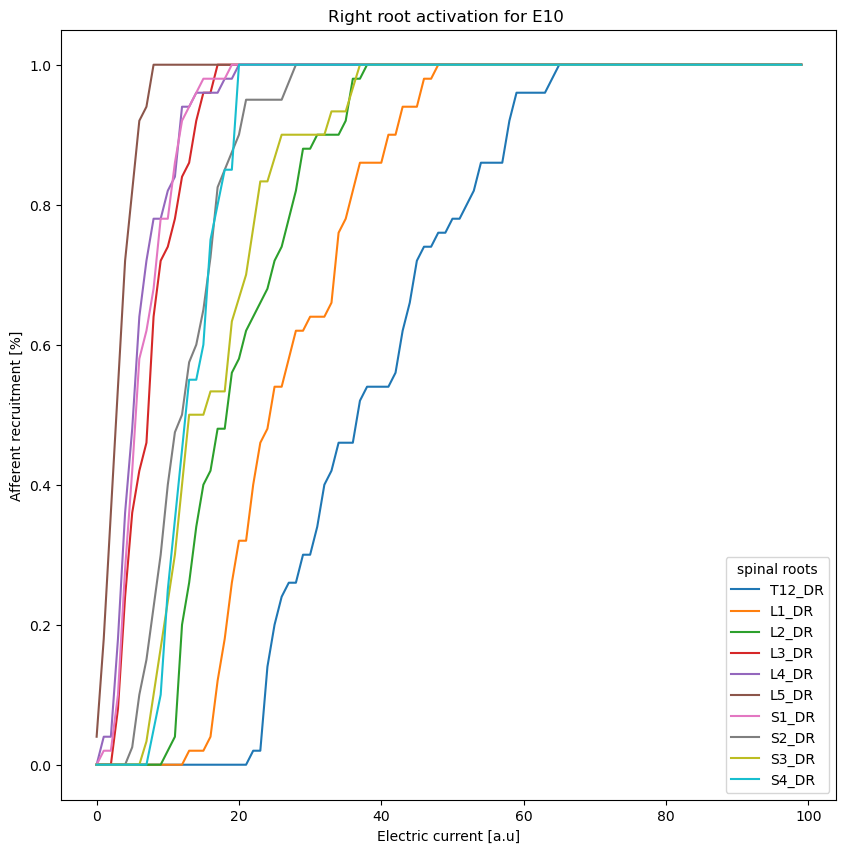

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E11_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

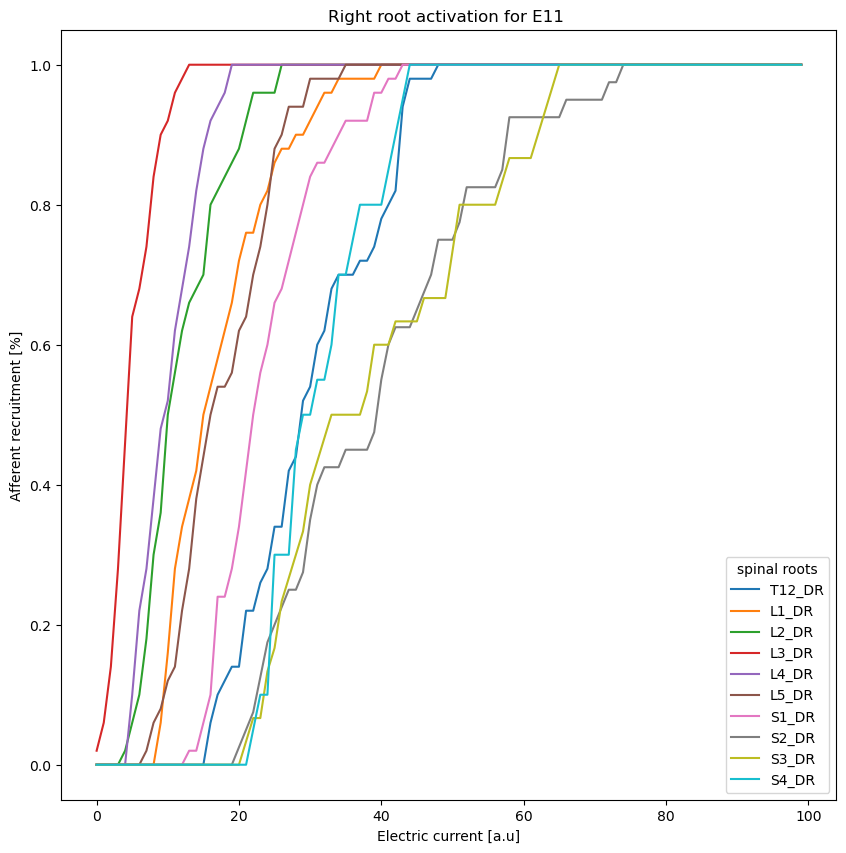

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E12_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

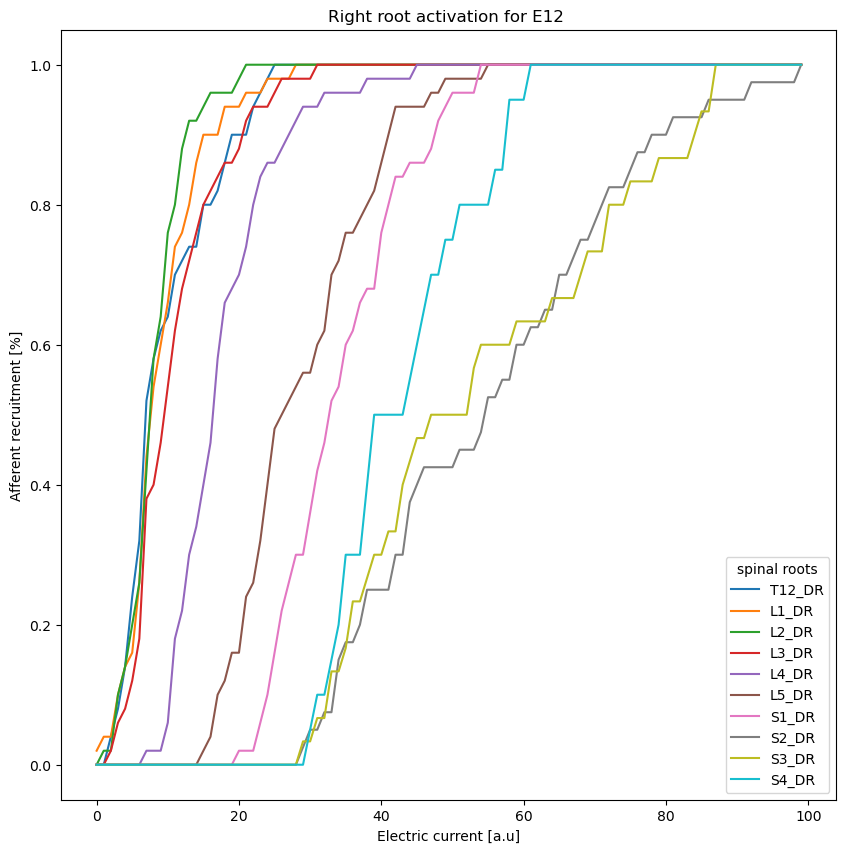

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E13_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

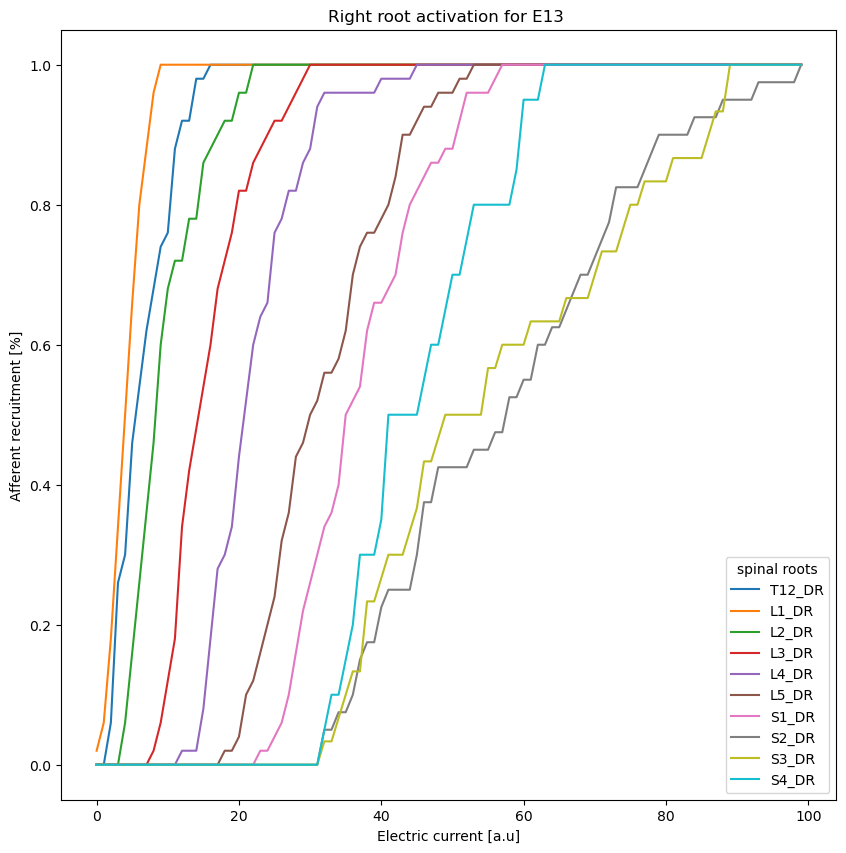

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E14_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

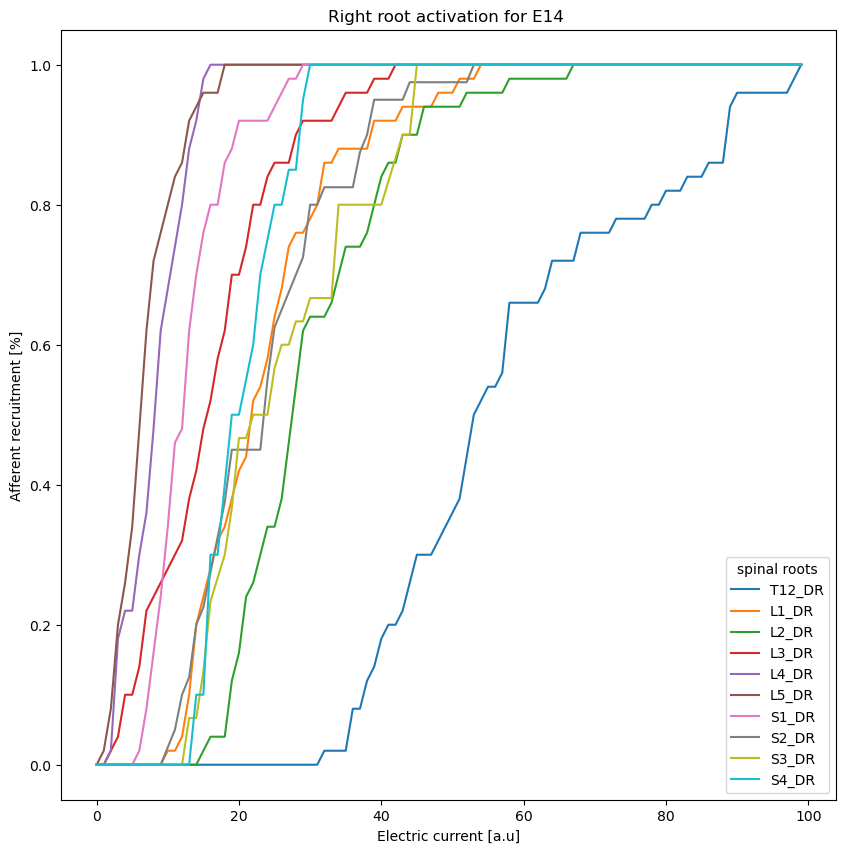

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_curve/roots/E15_recruitment_curve.png 
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/Recruitment_cur

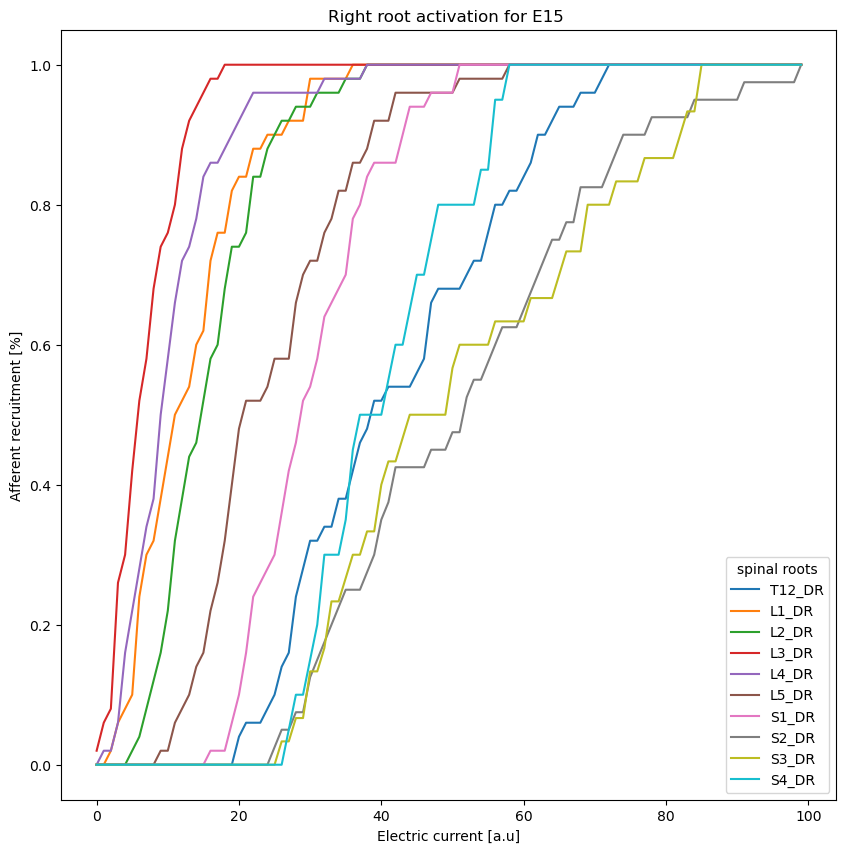

In [95]:
if save_plot:
    get_recruitment_curve_per_electrode(save_fig=save_plot)

## Build Heat map
For now the computation of the number to make a heatmap electrodes/roots 
we do one approach by taking the  electric current at the point where afferent recruitment reaches 100%.



### Normalisation/ Get nr for the heatmap

In [96]:
def get_number_for_heat_map_100_electric_current_normalise_by_max_root_response(electrodes_from_listing=electrodes_from_listing, roots=roots, recruitment_simulation= recruitment_simulation):

    """
    A function to get the number for the heatmap by by taking the  electric current 
    at the point where afferent recruitment reaches 100%.
    substracting this electric current from 100 
    and dividing it by the max muscle response for a muscle

    Parameters
    ----------
    electrodes_from_listing
        list, names of electrodes
    roots
        list, names of root
    recruitment_simulation
        dict with recruitment per electrode root combination,set by default
  
    Output
    ----------
    data_normalised_df
        df of values "normalised"
    """
    electric_current=np.zeros((len(roots),len(electrodes_from_listing)))
    for root_i in range(0, len(roots)):
        for elec_i in range (0, len(electrodes_from_listing)):
            # extract first index where recruitment =1.0
            # substract it from 100, since lower values in elec current show higher activation -> turn it
            electric_current[root_i ][elec_i]= 100-recruitment_simulation[f"_{electrodes_from_listing[elec_i]}_{roots[root_i]}"]["Recruitment"][np.where(1==recruitment_simulation[f"_{electrodes_from_listing[elec_i]}_{roots[root_i]}"]["Recruitment"])[0]].index[0]
            
    ## turn into a df
    # electric_current_df= pd.DataFrame(electric_current, columns=df_electrodes_for_roots["electrode_name"], index=df_roots["root_name"])
    electric_current_df= pd.DataFrame(electric_current, columns=df_electrodes_for_roots["electrode_name"], index=df_roots["root_name"])
    ##per root normalise it by max root response
    for root_i in roots:
        max_value_for_root=np.nanmax(electric_current_df.loc[root_i])
        electric_current_df.loc[root_i]=np.divide(electric_current_df.loc[root_i], max_value_for_root)

    print("normalisation method is: (100-electric_current)_normalise_by_max_root_response")
    return electric_current_df



In [97]:
def get_number_for_heat_map_100_electric_current(electrodes_from_listing=electrodes_from_listing, roots=roots, recruitment_simulation= recruitment_simulation):

    """
    A function to get the number for the heatmap by by taking the  electric current 
    at the point where afferent recruitment reaches 100%.
    substracting this electric current from 100 
    and dividing it by the max muscle response for a muscle

    Parameters
    ----------
    electrodes_from_listing
        list, names of electrodes
    roots
        list, names of root
    recruitment_simulation
        dict with recruitment per electrode root combination,set by default
  
    Output
    ----------
    data_normalised_df
        df of values "normalised"
    """
    electric_current=np.zeros((len(roots),len(electrodes_from_listing)))
    for root_i in range(0, len(roots)):
        for elec_i in range (0, len(electrodes_from_listing)):
            # extract first index where recruitment =1.0
            # substract it from 100, since lower values in elec current show higher activation -> turn it
            electric_current[root_i ][elec_i]= 100-recruitment_simulation[f"_{electrodes_from_listing[elec_i]}_{roots[root_i]}"]["Recruitment"][np.where(1==recruitment_simulation[f"_{electrodes_from_listing[elec_i]}_{roots[root_i]}"]["Recruitment"])[0]].index[0]
            
    ## turn into a df
    electric_current_df= pd.DataFrame(electric_current, columns=df_electrodes_for_roots["electrode_name"], index=df_roots["root_name"])

    print("normalisation method is: 100-electric_current")
    return electric_current_df




### Heat map all roots

In [98]:
get_number_for_heat_map_100_electric_current_normalise_by_max_root_response()


normalisation method is: (100-electric_current)_normalise_by_max_root_response


electrode_name       E00       E01       E02       E03       E04       E05  \
root_name                                                                    
T12_DL          0.735632  0.839080  0.172414  0.724138  0.770115  0.908046   
T12_DR          0.690476  0.892857  0.011905  0.011905  0.059524  0.011905   
L1_DL           0.636364  1.000000  0.693182  0.977273  0.875000  0.886364   
L1_DR           0.934066  0.890110  0.109890  0.318681  0.098901  0.186813   
L2_DL           0.921348  0.898876  0.674157  1.000000  0.887640  0.955056   
L2_DR           1.000000  0.951807  0.602410  0.698795  0.012048  0.506024   
L3_DL           0.585106  0.627660  0.808511  1.000000  0.882979  0.968085   
L3_DR           0.827586  0.804598  0.597701  0.689655  0.425287  0.793103   
L4_DL           0.364583  0.395833  0.885417  1.000000  0.947917  0.937500   
L4_DR           0.633333  0.611111  0.744444  0.777778  0.500000  0.911111   
L5_DL           0.357143  0.346939  0.918367  1.000000  0.979592  0.714286   
L5_DR           0.484536  0.484536  0.886598  0.886598  0.835052  0.701031   
S1_DL           0.447917  0.437500  0.916667  1.000000  0.895833  0.687500   
S1_DR           0.500000  0.477778  0.822222  0.800000  0.911111  0.766667   
S2_DL           0.163265  0.153061  0.979592  1.000000  0.775510  0.459184   
S2_DR           0.010526  0.010526  0.968421  0.989474  0.768421  0.410526   
S3_DL           0.371134  0.360825  0.979381  1.000000  0.845361  0.649485   
S3_DR           0.114583  0.114583  0.989583  0.989583  0.718750  0.489583   
S4_DL           0.404255  0.382979  0.968085  1.000000  0.861702  0.670213   
S4_DR           0.408602  0.397849  0.978495  0.989247  0.881720  0.677419   

electrode_name       E06       E07       E08       E09       E10       E11  \
root_name                                                                    
T12_DL          0.827586  1.000000  0.011494  0.011494  0.011494  0.195402   
T12_DR          0.047619  0.726190  0.476190  0.738095  0.416667  0.619048   
L1_DL           0.829545  0.988636  0.477273  0.238636  0.170455  0.011364   
L1_DR           0.571429  0.780220  0.395604  0.604396  0.571429  0.659341   
L2_DL           0.921348  0.910112  0.393258  0.258427  0.269663  0.404494   
L2_DR           0.626506  0.951807  0.771084  0.915663  0.746988  0.891566   
L3_DL           0.776596  0.617021  0.638298  0.510638  0.308511  0.585106   
L3_DR           0.758621  0.804598  0.793103  0.942529  0.954023  1.000000   
L4_DL           0.520833  0.375000  0.770833  0.625000  0.531250  0.760417   
L4_DR           0.644444  0.622222  0.900000  1.000000  0.888889  0.900000   
L5_DL           0.346939  0.346939  0.846939  0.744898  0.693878  0.500000   
L5_DR           0.474227  0.484536  0.979381  1.000000  0.948454  0.670103   
S1_DL           0.447917  0.427083  0.802083  0.729167  0.791667  0.614583   
S1_DR           0.500000  0.477778  0.944444  1.000000  0.900000  0.633333   
S2_DL           0.163265  0.153061  0.938776  0.857143  0.581633  0.357143   
S2_DR           0.010526  0.010526  1.000000  1.000000  0.757895  0.273684   
S3_DL           0.371134  0.360825  0.958763  0.917526  0.773196  0.556701   
S3_DR           0.114583  0.114583  1.000000  0.989583  0.656250  0.364583   
S4_DL           0.393617  0.382979  0.957447  0.904255  0.819149  0.585106   
S4_DR           0.408602  0.387097  1.000000  0.978495  0.860215  0.602151   

electrode_name       E12       E13       E14       E15  
root_name                                               
T12_DL          0.080460  0.390805  0.379310  0.367816  
T12_DR          0.892857  1.000000  0.011905  0.333333  
L1_DL           0.045455  0.852273  0.625000  0.522727  
L1_DR           0.791209  1.000000  0.505495  0.703297  
L2_DL           0.460674  0.876404  0.741573  0.707865  
L2_DR           0.951807  0.939759  0.397590  0.746988  
L3_DL           0.574468  0.606383  0.840426  0.734043  
L3_DR           0.793103  0.804598  0.666667  0.94252

In [99]:

def get_heatmap_all_roots_overview(save_fig=save_plot, roots=roots, electrodes_from_listing=electrodes_from_listing):
    """
    A function to create a heatmap.

    Parameters
    ----------

    save_fig
        int, if set to 1 save figure
    roots
        list of all the muscles in the gait, set by default
    electrodes_from_listing
        list of all the electrodes used, set by default
    """
            
    fig, ax = plt.subplots(figsize=(15,10))# creating subplot

    ## Define which normalisation method is used
    data=get_number_for_heat_map_100_electric_current_normalise_by_max_root_response()
    data_structure="100-electric_current_div_max_root_response"
    # data=get_number_for_heat_map_100_electric_current()
    # data_structure="100-electric_current"
    
    ## Define heatmap
    sns.heatmap(data=data, cmap="Reds", cbar=True,
    annot=True,  yticklabels=roots,
    xticklabels=electrodes_from_listing,
    cbar_kws={'label': f"Root activation [a.u]"},
    fmt='.2g' )
 
    ## Define ticks
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    ## Define labels
    ax.set_title('Heat map for root activation per electrode', size=18, fontstyle='italic', pad=20)
    ax.set_ylabel('Roots',  size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold") 
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Electrodes', size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold")

    
    ## Define Textbox
    print(f"Heat map is being created with Normalisation method: {data_structure}")
    axbox = fig.add_axes([0, 1.0, 0.2, 0.05]) #[left, bottom, width, height]
    text_box = TextBox(axbox,label=None, textalignment="center")
    text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

    ## Save plots   
    if save_fig:
        folder_name= "heatmap/muscles"
        data_file = "Heat_map_all_muscles_"+ data_structure+'_'+subject+'.png'
        save_figure(folder_name, data_file)

    plt.show()


normalisation method is: (100-electric_current)_normalise_by_max_root_response
Heat map is being created with Normalisation method: 100-electric_current_div_max_root_response
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/muscles/Heat_map_all_muscles_100-electric_current_div_max_root_response_MR012.png 


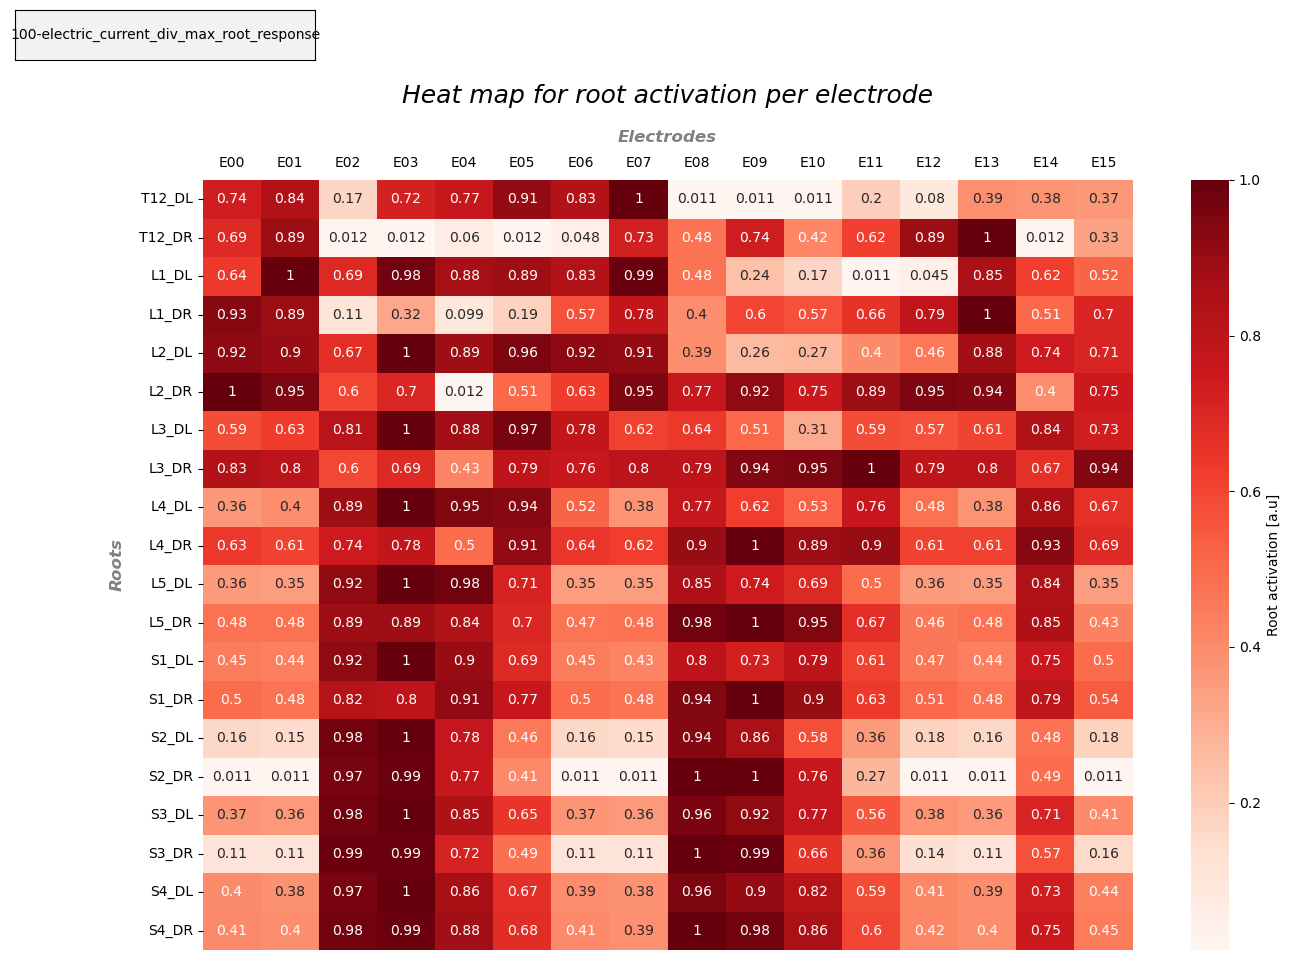

In [100]:
if save_plot:
    get_heatmap_all_roots_overview(save_fig=save_plot)

### Heat map indiviudal roots, paddle lead arrangement

#### Functions for the heatmap

In [101]:
### Interpolate unknown values in the heat map ###

def interpolate_missing_pixels(image, mask, method, fill_value=0):

    """
    A function to interpolate missing values.
    
    Parameters
    ----------
    image 
        2D np.array
    mask
        a 2D boolean array, True indicates missing values
    method
        interpolation method, one of 'nearest', 'linear', 'cubic'.
    fill_value
        which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
        
    Return
    ----------
    interp_image
        nd.array with missing values interpolated
    """

    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image


In [102]:
### text to define electrodes in plot
text = np.array([
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','1', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '7','', '','', '', '', '13', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','0', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '6','', '','', '', '', '12', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','15', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '5','', '','', '', '', '11', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','14', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '4','', '','', '', '', '10', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '3','', '2','', '8', '', '9', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', '']])

In [103]:
# Modify image
def get_cropped_image(location_image=location_image, lead=0, spinalcord=0):
    """
    Function to crop the paddle lead image

    location_image
        directory of image
    Define which image
        lead
            image of the paddle lead, zero by default
        spinalcord
            image of the spinal cord, zero by default
    """
    if lead:
        # Opens a image in RGB mode
        load_image=os.path.join(location_image,"lead.png")
        # Setting the points for cropped image
        left = np.divide(513-323, 2)
        top=55
        right = left+323
        bottom = top+1874
        
    if spinalcord:
        # Opens a image in RGB mode
        load_image=os.path.join(location_image,"Spinal_cord.png")
        # Setting the points for cropped image
        left = 123
        top = 18
        right = 123+157
        bottom = 18+679
    
    # Cropped image of above dimension
    # (It will not change original image)
    im = Image.open(load_image)
    im1 = im.crop((left, top, right, bottom))
    
    # Shows the image in image viewer
    return im1
    


#### Plot the heatmap

In [104]:
##  change background
def get_heat_map_individual_root_recruitment(interpolation=0, save_fig=save_plot, interpol_method='cubic', text=text, roots=roots, electrodes=electrodes):
    """
    A function to create a heatmap  with and without interpolation.
    -Interpolation method can be adapted 'nearest', 'linear', 'cubic', by changing the interpolation function
    -data fed to the heatmap can be adapted by changing the 'get_number_for_heatmap' function


    Parameters
    ----------
    interpolation
        int, if set to one, generates heat maps with interpolation, 0 by default
    save_fig
        int, if set to 1 save figure, 0 by default
    interpol_method
        interpolation method, one of 'nearest', 'linear', 'cubic'
    text
        array used for annotation; to define electrodes in the plot
    roots
        list of all the roots in the gait, set by default ('T12_DL', 'T12_DR', 'L1_DL'...)
    electrodes
        list of all the electrodes used, set by default ('E00', 'E01', 'E02'...)

    """

   ## Define which normalisation method is used
    data=get_number_for_heat_map_100_electric_current()
    data_structure="100-electric_current"
    # data=get_number_for_heat_map_100_electric_current_normalise_by_max_root_response() # this wont work well bc interpolation doesnt work between 0 and 1
    # data_structure="100-electric_current_div_max_root_response"
   


    ## Define paddle lead
    if interpolation:
        print("Heat map s being interpolated")
        # Build tensor filled with -1, thus undefined values are easily recognisable ##    
        paddle_lead =np.zeros(80* 9)
        paddle_lead=np.array([-1]*len(paddle_lead))
        paddle_lead=paddle_lead.reshape((80,9))
        method="interpolated"

    else:
        print("No interpoaltion is used for the heat map")
        method="non_interpolated"
        paddle_lead =np.zeros(80* 9)
        paddle_lead=paddle_lead.reshape((80,9))

    ## Get the lead image as an array so we can plot it ##
    map_img=get_cropped_image(lead=1)
    ## For every root fill paddle lead with values ##
    for root in roots:
        # Set settings for plot ## 
        fig, ax = plt.subplots(figsize=(3,10))# creating subplot
        # Set title
        ax.set_title(f"{method} heat map for {root}", size=18, fontstyle='italic', pad=20)
    
        # Define electrode placements
        numbers=[1, 0, 15, 14]
        for index, number in enumerate(numbers, start=0): 
            n=(14*index)+3 # equal spacing
            row=4
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[root, electrodes[e]]
                    # print(i+n)

        numbers=[7, 6, 5, 4]
        for index, number in enumerate(numbers, start=0):  
            n=(14*index)+10 # equal spacing
            row=1
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
            
                    paddle_lead[i+n][row] =data.loc[root, electrodes[e]]

        numbers=[13, 12, 11, 10]
        for index, number in enumerate(numbers, start=0):   
            n=(14*index)+10 # equal spacing
            row=7
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[root, electrodes[e]]

        numbers=[3, 2, 8, 9]
        for index, number in enumerate(numbers, start=0):  
            n=55+10
            row=1+(index*2)
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[root, electrodes[e]]
        
        if interpolation:
            # interpolate unknown values
            # Create boolean, with true for the unknown values, which were set to -1, for interpolation #
            mask=paddle_lead<0

            ## Get interpolation for the unknown values ##
            interpolated_image=interpolate_missing_pixels(
            image=paddle_lead,
            mask=mask,
            method=interpol_method,
            fill_value= 0
            )

            ## Set values outside of lead to zero ##
            # do it after interpolation that this doent get taken into account for interpol
            nr_columns=[8, 4, 2, 1, 1, 1, 2, 4, 8]
            for index, columns in enumerate(nr_columns):
                for col in range(0, columns):
                        interpolated_image[col][0+index] =0

            nr_columns=[7, 5,4, 4, 4, 4,4, 5, 7]
            for index, columns in enumerate(nr_columns):
                for col in range(79, 79-columns, -1):
                        interpolated_image[col][0+index] =0

            
        ## Drawing heatmap on current axes ##
        if interpolation:
            hmax= sns.heatmap(
                data=interpolated_image, annot=text, fmt="",
                cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
                cbar_kws={'label': "Muscle activation [V/A]"},
                yticklabels=False, xticklabels=False, vmin=0, 
                vmax=100, 
                alpha = 0.75, # whole heatmap is translucent
                zorder = 2,
                    )
        else:
            hmax= sns.heatmap(
            data=paddle_lead, annot=text, fmt="",
            cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
            cbar_kws={'label': "Muscle activation [V/A]"},
            yticklabels=False, xticklabels=False, vmin=0, 
            vmax=100, 
            alpha = 0.75, # whole heatmap is translucent
            zorder = 2,
                )
        
        ## put the image under the heatmap
        hmax.imshow(map_img,
            aspect = hmax.get_aspect(),
            extent =hmax.get_xlim() + hmax.get_ylim(),
            zorder = 1) 
        
        # ## Define Textbox
        # axbox = fig.add_axes([-0.5, 1.0, 1., 0.05]) #[left, bottom, width, height]
        # text_box = TextBox(axbox,label=None, textalignment="center")
        # text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

        ## Save plots 
        if save_fig:
            folder_name= f"heatmap/roots/{method}/{data_structure}"
            data_file =root+"_"+"heat_map"+'_'+subject+'.png'
            save_figure(folder_name, data_file)
        show() 


normalisation method is: 100-electric_current
Heat map s being interpolated
 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/T12_DL_heat_map_MR012.png 


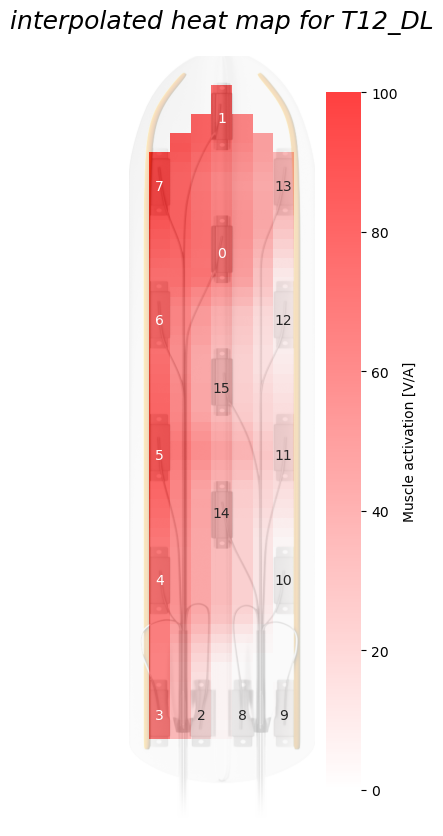

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/T12_DR_heat_map_MR012.png 


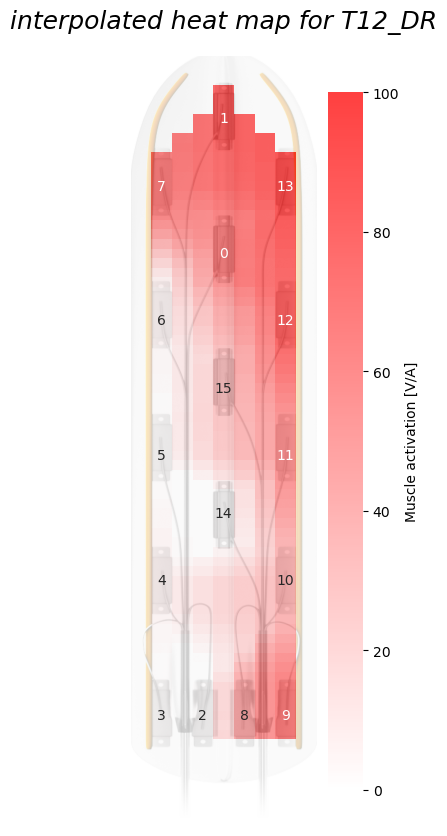

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L1_DL_heat_map_MR012.png 


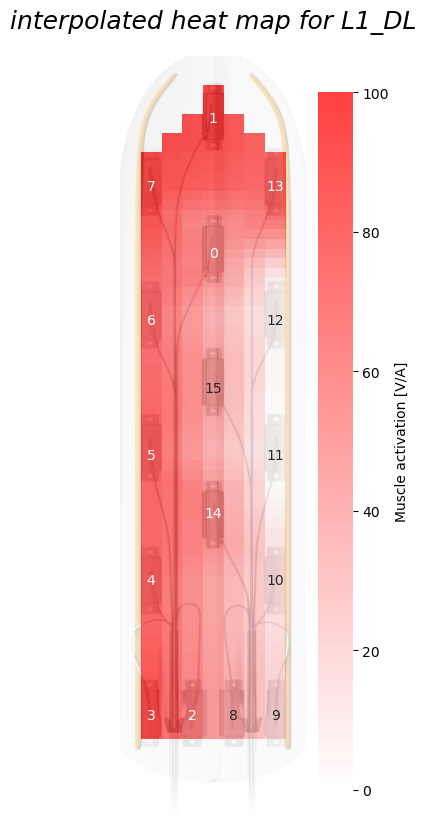

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L1_DR_heat_map_MR012.png 


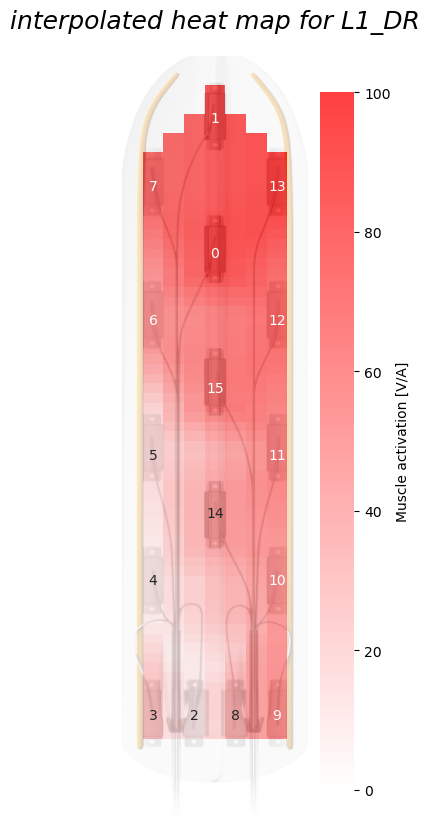

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L2_DL_heat_map_MR012.png 


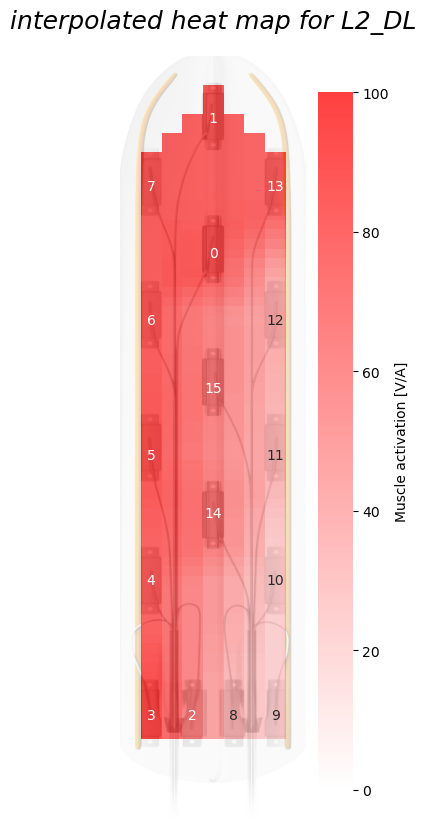

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L2_DR_heat_map_MR012.png 


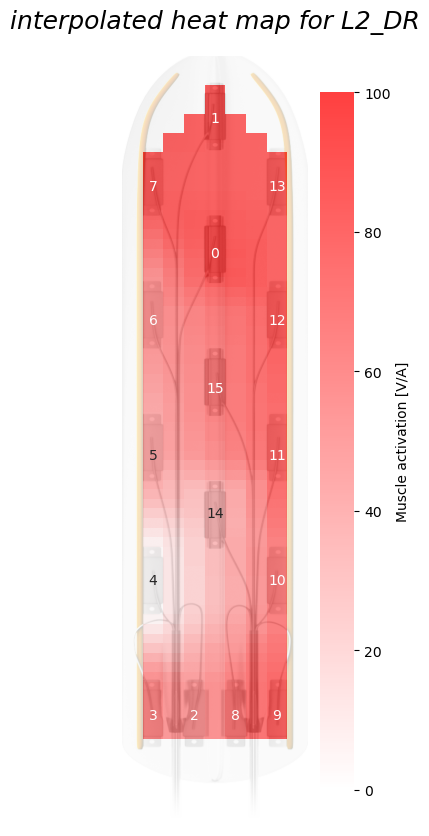

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L3_DL_heat_map_MR012.png 


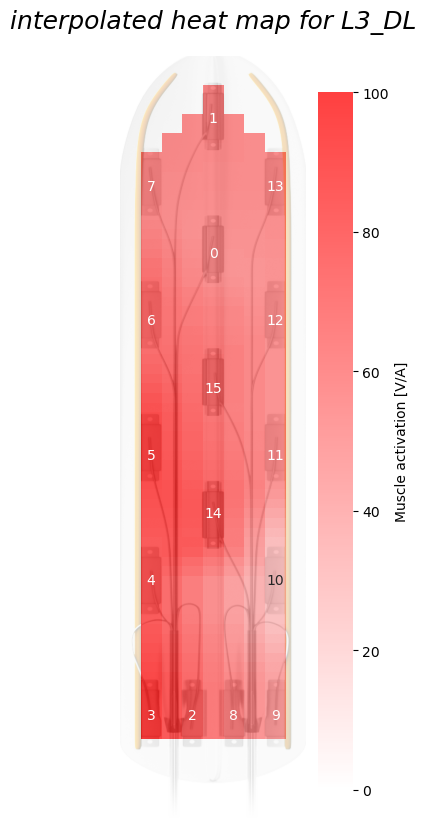

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L3_DR_heat_map_MR012.png 


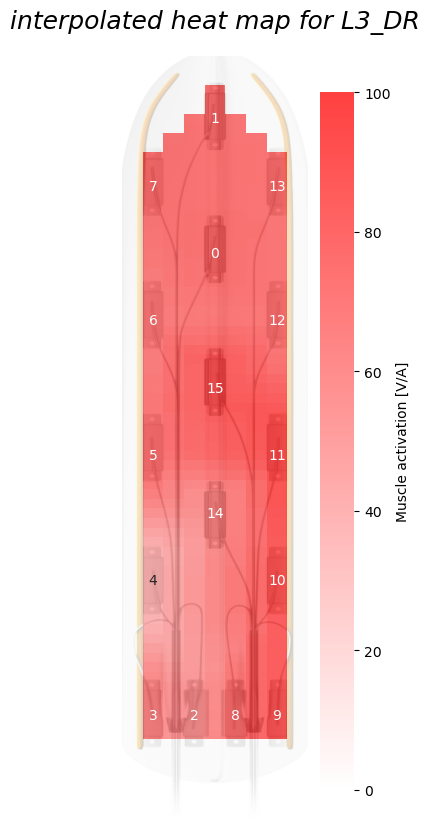

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L4_DL_heat_map_MR012.png 


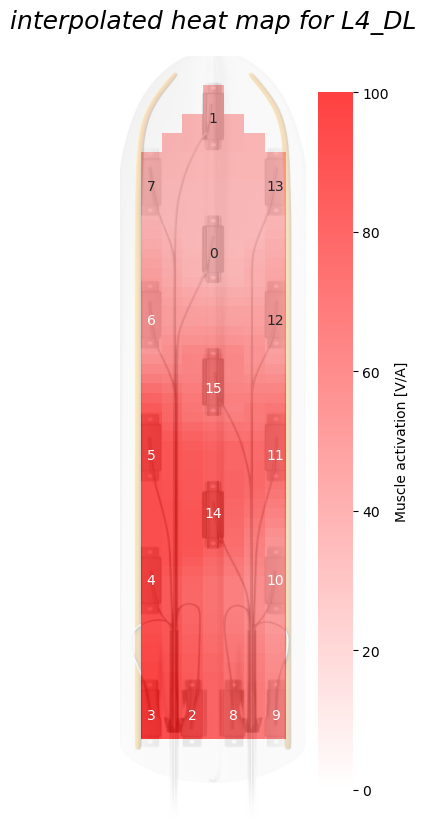

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L4_DR_heat_map_MR012.png 


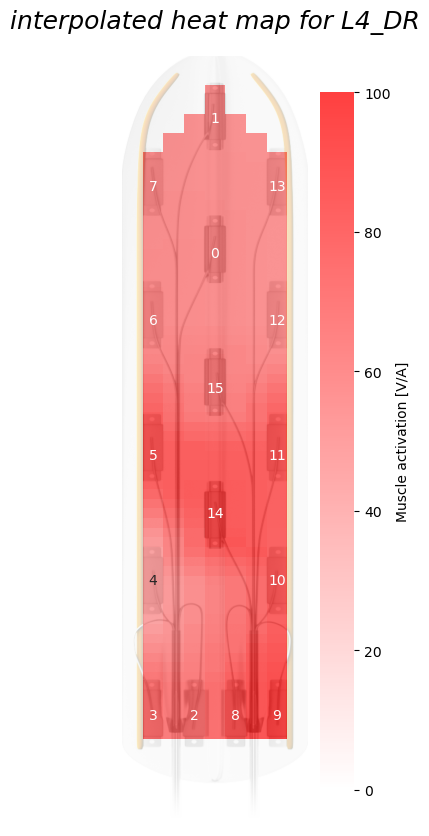

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L5_DL_heat_map_MR012.png 


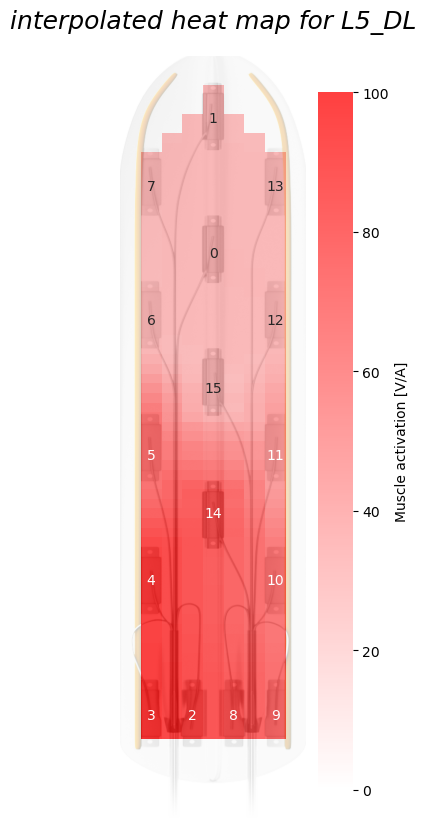

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/L5_DR_heat_map_MR012.png 


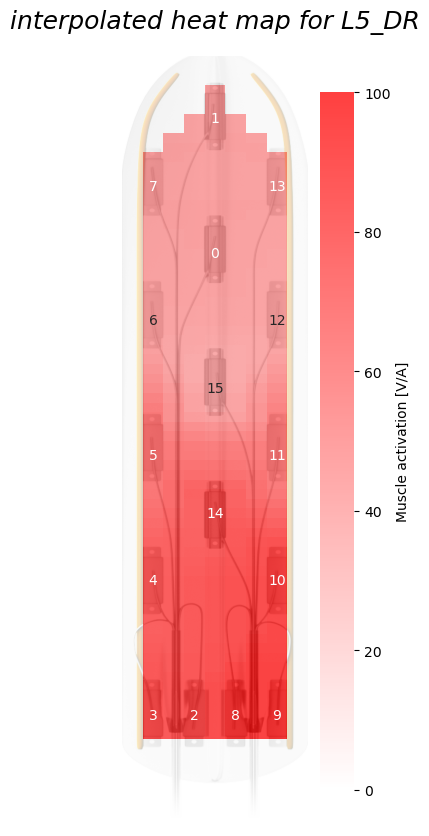

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/S1_DL_heat_map_MR012.png 


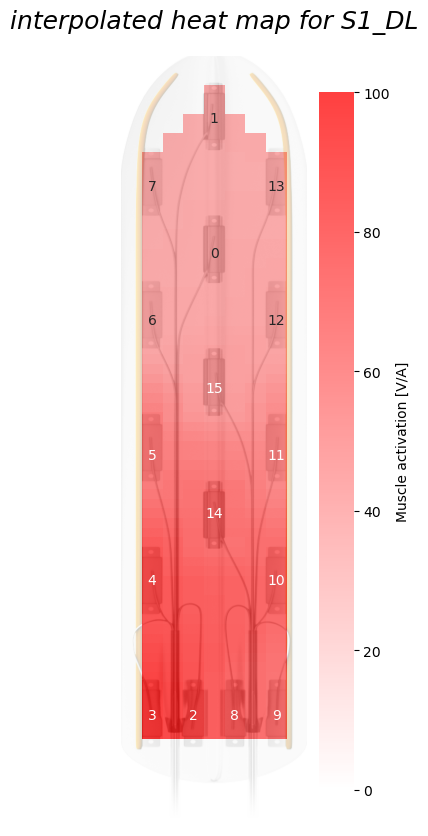

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/S1_DR_heat_map_MR012.png 


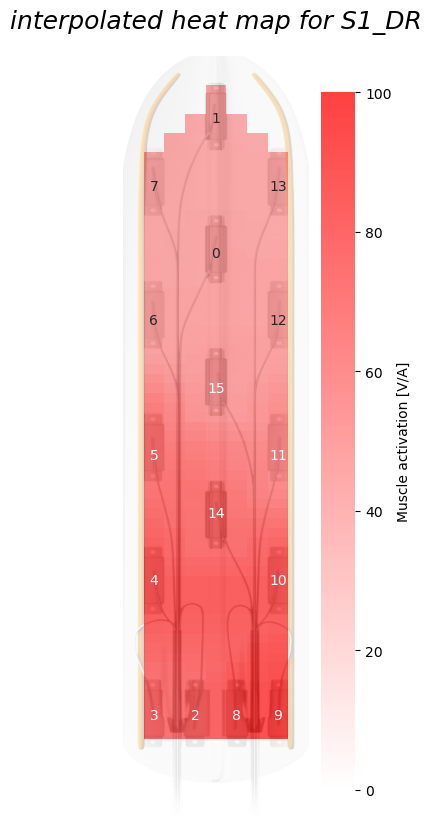

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/S2_DL_heat_map_MR012.png 


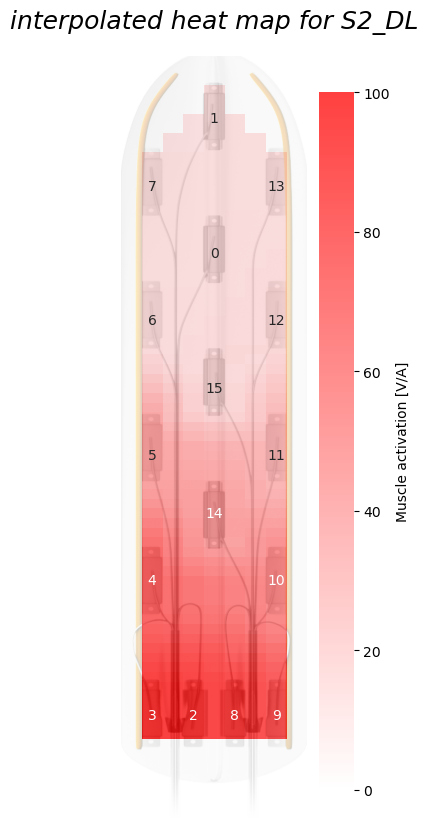

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/S2_DR_heat_map_MR012.png 


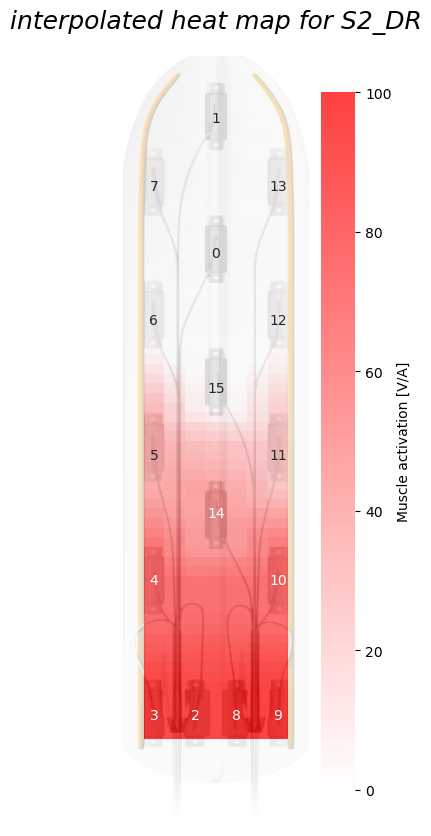

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/S3_DL_heat_map_MR012.png 


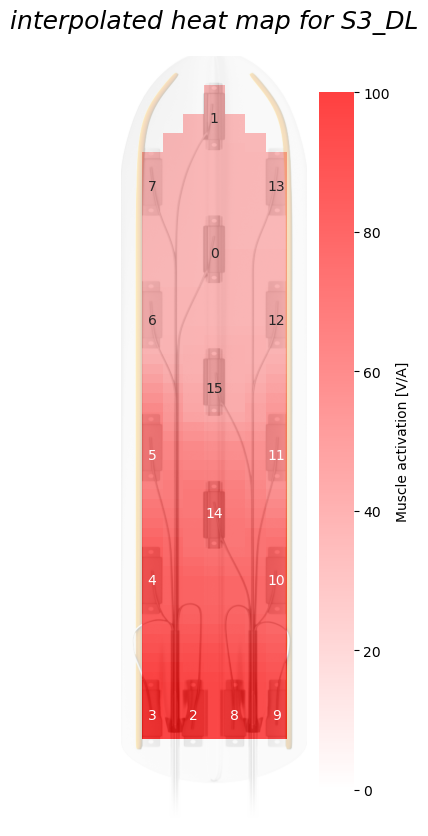

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/S3_DR_heat_map_MR012.png 


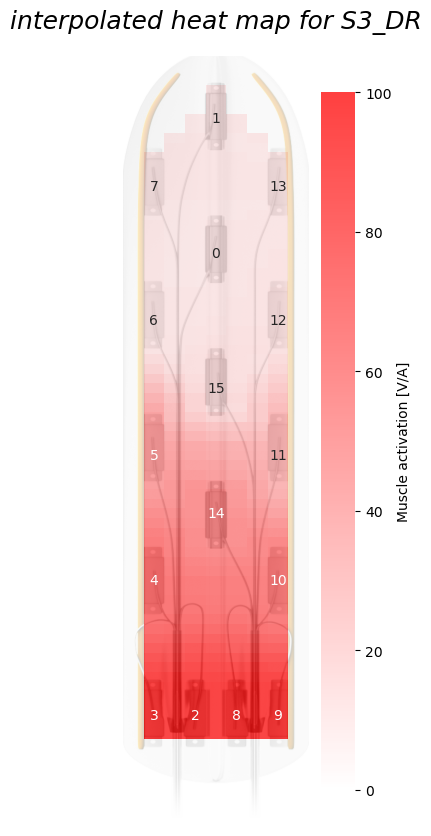

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/S4_DL_heat_map_MR012.png 


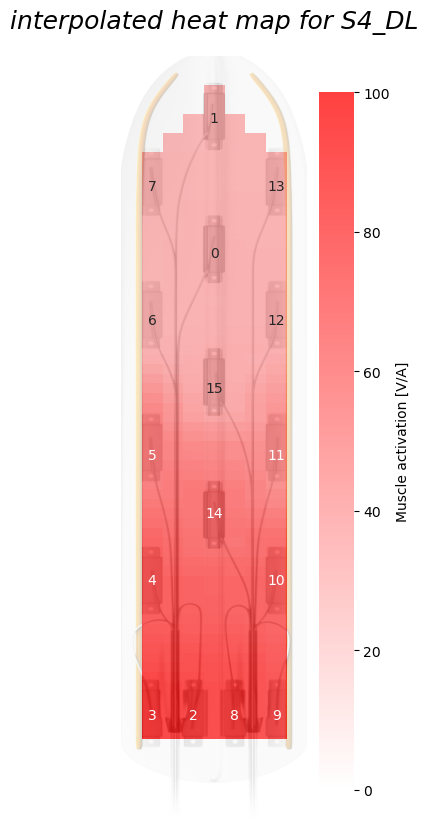

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/heatmap/roots/interpolated/100-electric_current/S4_DR_heat_map_MR012.png 


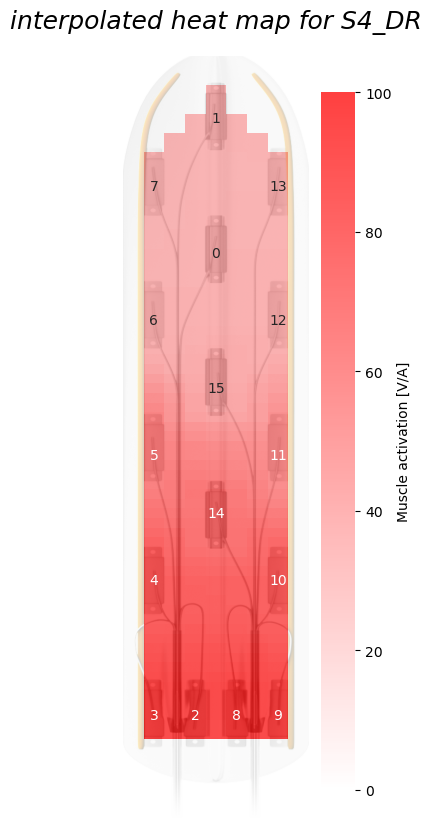

In [105]:
if save_plot:
    get_heat_map_individual_root_recruitment(save_fig=save_plot, interpolation=1)


## Fit sigmoid

In [106]:
def sigmoid(x, L ,x0, k, b):
    """
    A function to define a sigmoid curve.

    Parameters
    ----------
    L 
        is the limes
    x0 
        is the point in the middle of the Sigmoid, i.e. the point where Sigmoid should originally output the value 1/2 
    k 
        the slope; is responsible for scaling the input, which remains in (-inf,inf)
    b 
        adds bias 
     """


    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

In [119]:

# version taken from muscles
def fit_sigmoid_max_value_given(elec_i,root_i,save_fig=save_plot,data=roots_recruitment_to_tensor):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------
    elec_i
        int, nr of electrode
    root_i
        int, nr of muscle
    save_fig
        int, if set to 1 save figure, default set to 0 
    data
        ..
    electrodes_from_listing
        list, all ellectrodes used in data, set by default
    roots_left, roots_right
        list, all roots used in data, separated left and right, set by default
  
    Output
    ----------
    pcov 
        is the error of a parameter in the model, Does the changing of the parameter slightly give a better fit? 
        if pcov is very big, (=bad) , changing of the parameter doesnt have big of a influence, this we dont really know what is the (optimal) parameter 
    popt 
        is the optimal parameters for the function
    """

    ## variables for plot
    colors = cm.rainbow(np.linspace(0, 1, len(roots_right)))
    label=roots_right

    # creating subplot
    fig, ax = plt.subplots(figsize=(10,7))
    
    ## set known x and y values
    ydata=np.array(data[elec_i,root_i, :]) # turn tensor into array
    xdata = np.arange(0, 100)# set x for y
   
    ## Initial guess for the parameters ##
    ## Get optimal parameters for sigmoid curve
    p0 =[max(ydata) ,np.median(xdata), 0.5, min(ydata)]

    ## to avoid RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ##smoothen data if needed
    try:
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )

    except:
        print("############################################################")
        print(" Avoid RuntimeError")
        ## smoothen the data by convoluting it with a rectangle 
        # seems to look smoother, but is this feasible with so few data points?
        filt= np.ones(3)/3 # setting window to three points
        ydata_smooth= np.convolve(ydata, filt, mode="valid")
        ydata=ydata_smooth
        xdata=xdata[1:-1] # change borders, since we need space for the window
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )

    print(f"opt:{popt}")
    print(f"pcov:{pcov}")
    ## define x and y for sigmoidal curve
    #interpolation should start before data and end a little after ( to see asymptote)

    x=np.linspace(0, xdata[-1], 100) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
    y = sigmoid(x, *popt)

    ###################
    ## PLOT SETTINGS ##
    ###################

    ax.plot(xdata, ydata, 'o', c=colors[root_i])
    ax.plot(x,y,  label=label[root_i], c=colors[root_i])

    # Add text descripiton to the points for visibility
    ax.text(x[-1], y[-1], label[root_i],c=colors[root_i], size=10) 

    ## set ticks
    # ax.set_xticks() 
    # ax.set_yticks()

    ## set titles
    ax.set_xlabel("Electric current [a.u]")
    ax.set_ylabel("Recruitment [?]")
    plt.legend(title="roots")
    plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
    
    ## save plots ##
    if save_fig:
        data_file = "elec"+"_"+str(elec_i)+"_"+"sigmoid_fit"+'_'+subject+'.png'
        folder_name="sigmoidal_fit/roots"
        save_figure(folder_name, data_file)


    plt.show()

    return popt
    


In [ ]:
data=roots_recruitment_to_tensor
elec_i=0
root_i=0
root_side=roots_right
## variables for plot


# variables for plot
label=root_side
colors = cm.rainbow(np.linspace(0, 1, len(root_side)))
palette={}
for i in range(0, len(root_side)):
    palette[root_side[i]] = colors[i]
# creating subplot
fig, ax = plt.subplots(figsize=(10,7))
    

for root_i in range(len(root_side)):

    ## set known x and y values
    ydata=np.array(data[elec_i,root_i, :]) # turn tensor into array
    xdata = np.arange(0, 100)# set x for y

    ## Initial guess for the parameters ##
    ## Get optimal parameters for sigmoid curve
    p0 =[max(ydata) ,np.median(xdata), 0.5, min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
    # bounds=(0,L)
    maxfev=10000
    )

    ## define x and y for sigmoidal curve
    #interpolation should start before data and end a little after ( to see asymptote)

    x=np.linspace(0, xdata[-3], 100) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
    y = sigmoid(x, *popt)

    ###################
    ## PLOT SETTINGS ##
    ###################

    ## combine data to a table to be able to make a nice legend
    ## combine datapoints, and fitted points
    
    data_points = {'x': xdata,
            'y': ydata,
            'type': np.array(["data"]*len(xdata)), 
            'name': np.array([root_side[root_i]]*len(xdata))
            }

    data_points = pd.DataFrame(data_points)
    fit = {'x': x,
            'y': y,
            'type': np.array(["fit from data"]*len(x)), 
            'name': np.array([root_side[root_i]]*len(x))
            }

    fit = pd.DataFrame(fit)
    combined=pd.concat([data_points, fit])
    # solve  ValueError: cannot reindex from a duplicate axis.
    combined = combined.reset_index(drop=True)
    # sns.scatterplot(data=combined, x="x", y="y", hue="name", style="type", palette=palette)
    sns.lineplot(data=combined, x="x", y="y", hue="name", style="type", palette=palette)
    # sns.lineplot(data=combined, x="x", y="y", hue="name", style="type")

    # ax.plot(xdata, ydata, 'o', c=colors[root_i])
    # ax.plot(x,y,  label=label[root_i], c=colors[root_i])

    # Add text descripiton to the points for visibility
    ax.text(x[-1], y[-1], label[root_i],c=colors[root_i], size=10) 
    # ax.text(x[-1], y[-1], label[root_i],c=palette, size=10) 

    ## set ticks
    # ax.set_xticks() 
    # ax.set_yticks()

## set titles
ax.set_xlabel("Electric current [a.u]")
ax.set_ylabel("Recruitment [?]")
# plt.legend(title="roots")
plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")

handles, labels = plt.gca().get_legend_handles_labels()
# print(handles, labels)
by_label = dict(zip(labels, handles))
print(by_label)
plt.legend(by_label.values(), by_label.keys()) 

In [229]:

# per root
def fit_sigmoid_max_value_given(elec_i,root_i,root_side=0, save_fig=save_plot,data=roots_recruitment_to_tensor):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------
    elec_i
        int, nr of electrode
    root_i
        int, nr of muscle
    root_side
        0 roots_right
        1 roots_left
    save_fig
        int, if set to 1 save figure, default set to 0 
    data
        ..
    electrodes_from_listing
        list, all ellectrodes used in data, set by default
    roots_left, roots_right
        list, all roots used in data, separated left and right, set by default
  
    Output
    ----------
    pcov 
        is the error of a parameter in the model, Does the changing of the parameter slightly give a better fit? 
        if pcov is very big, (=bad) , changing of the parameter doesnt have big of a influence, this we dont really know what is the (optimal) parameter 
    popt 
        is the optimal parameters for the function
    """


    ## variables for plot
    if root_side:
        root_side=roots_left
    else:
        root_side=roots_right
    
    label=root_side
    colors = cm.rainbow(np.linspace(0, 1, len(root_side)))
    palette={}
    for i in range(0, len(root_side)):
        palette[root_side[i]] = colors[i]
    # creating subplot
    fig, ax = plt.subplots(figsize=(10,7))
    
    ## set known x and y values
    ydata=np.array(data[elec_i,root_i, :]) # turn tensor into array
    xdata = np.arange(0, 100)# set x for y
   
    ## Initial guess for the parameters ##
    ## Get optimal parameters for sigmoid curve
    p0 =[max(ydata) ,np.median(xdata), 0.5, min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
    # bounds=(0,L)
    maxfev=10000
    )

    ## define x and y for sigmoidal curve
    #interpolation should start before data and end a little after ( to see asymptote)

    x=np.linspace(0, xdata[-3], 100) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
    y = sigmoid(x, *popt)

    ###################
    ## PLOT SETTINGS ##
    ###################

    ## combine data to a table to be able to make a nice legend
    ## combine datapoints, and fitted points
    
    data_points = {'x': xdata,
            'y': ydata,
            'type': np.array(["data"]*len(xdata)), 
            'name': np.array([root_side[root_i]]*len(xdata))
            }

    data_points = pd.DataFrame(data_points)
    fit = {'x': x,
            'y': y,
            'type': np.array(["fit from data"]*len(x)), 
            'name': np.array([root_side[root_i]]*len(x))
            }

    fit = pd.DataFrame(fit)
    combined=pd.concat([data_points, fit])
    # solve  ValueError: cannot reindex from a duplicate axis.
    combined = combined.reset_index(drop=True)
    # sns.scatterplot(data=combined, x="x", y="y", hue="name", style="type", palette=palette)
    sns.lineplot(data=combined, x="x", y="y", hue="name", style="type", palette=palette)
    # sns.lineplot(data=combined, x="x", y="y", hue="name", style="type")

    # ax.plot(xdata, ydata, 'o', c=colors[root_i])
    # ax.plot(x,y,  label=label[root_i], c=colors[root_i])

    # Add text descripiton to the points for visibility
    ax.text(x[-1], y[-1], label[root_i],c=colors[root_i], size=10) 
    # ax.text(x[-1], y[-1], label[root_i],c=palette, size=10) 

    ## set ticks
    # ax.set_xticks() 
    # ax.set_yticks()

    ## set titles
    ax.set_xlabel("Electric current [a.u]")
    ax.set_ylabel("Recruitment [?]")
    plt.legend(title="roots")
    plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
    
    ## save plots ##
    if save_fig:
        data_file = "elec"+"_"+str(elec_i)+"_"+"sigmoid_fit"+'_'+subject+'.png'
        folder_name="sigmoidal_fit/roots"
        save_figure(folder_name, data_file)


    plt.show()

    return popt
    


 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_0_sigmoid_fit_MR012.png 


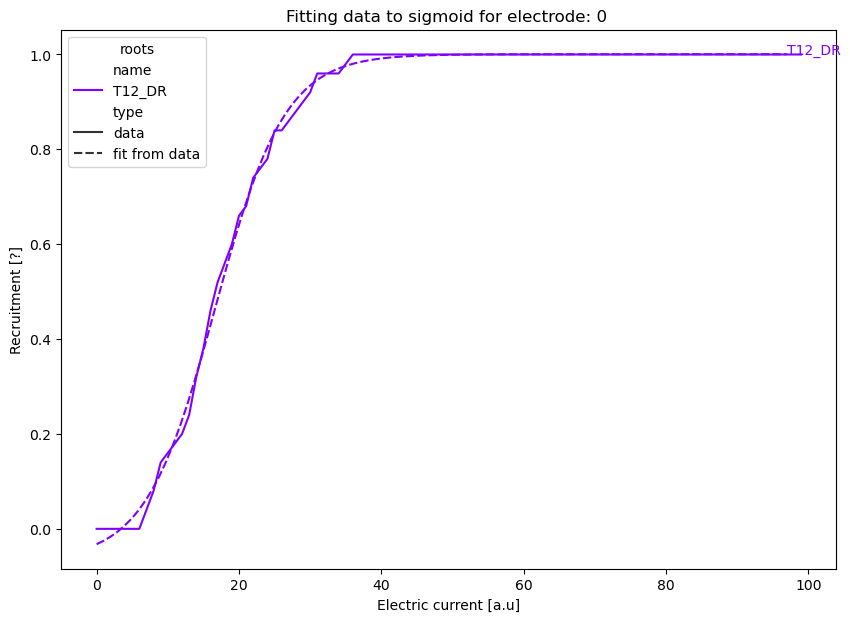

array([ 1.06693782, 16.69363189,  0.20459809, -0.06637053])

In [230]:
fit_sigmoid_max_value_given(elec_i=0, root_i=0, root_side=0)

In [281]:
def get_fit_for_data(xdata, ydata):
       """
       Function to get sigmoid fit for data 
       
       xdata 
              datapoints for x value, same length as ydata
       ydata
              datapoints for y value
      
       """
       ## Initial guess for the parameters ##
       ## Get optimal parameters for sigmoid curve
       p0 =[max(ydata) ,np.median(xdata), 0.5, min(ydata)]
       popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
       # bounds=(0,L)
       maxfev=10000
       )
       ## define x and y for sigmoidal curve
       #interpolation should start before data and end a little after ( to see asymptote)

       x=np.linspace(0, xdata[-3], len(xdata-3)) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
       y = sigmoid(x, *popt)

       return x, y

In [282]:


def get_df_combined(root_side, elec_i):
        """
        Function to get xdata,ydata and combine it with fitted data to a df
        """
        data_you_need=pd.DataFrame()
        for root_i in range(len(root_side)):
                ydata=np.array(data[elec_i,root_i, :]) # turn tensor into array
                xdata = np.arange(0, 100)# set x for y
                x,y=get_fit_for_data(xdata=xdata, ydata=ydata)


                ## combine data to a table to be able to make a nice legend
                ## combine datapoints, and fitted points
                
                data_points = {'x': xdata,
                        'y': ydata,
                        'type': np.array(["data"]*len(xdata)), 
                        'name': np.array([root_side[root_i]]*len(xdata))
                        }

                data_points = pd.DataFrame(data_points)
                fit = {'x': x,
                        'y': y,
                        'type': np.array(["fit from data"]*len(x)), 
                        'name': np.array([root_side[root_i]]*len(x))
                        }
                fit = pd.DataFrame(fit)
                combined=pd.concat([data_points, fit])
                data_you_need=pd.concat([data_you_need, combined])

        return data_you_need



In [289]:

# combine all data to df
def fit_sigmoid_max_value_given(root_side=0, save_fig=1,data=roots_recruitment_to_tensor,electrodes_from_listing=electrodes_from_listing ):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------
    elec_i
        int, nr of electrode
    root_i
        int, nr of muscle
    root_side
        0 roots_right
        1 roots_left
    save_fig
        int, if set to 1 save figure, default set to 0 
    data
        ..
    electrodes_from_listing
        list, all ellectrodes used in data, set by default
    roots_left, roots_right
        list, all roots used in data, separated left and right, set by default
  
    Output
    ----------
    pcov 
        is the error of a parameter in the model, Does the changing of the parameter slightly give a better fit? 
        if pcov is very big, (=bad) , changing of the parameter doesnt have big of a influence, this we dont really know what is the (optimal) parameter 
    popt 
        is the optimal parameters for the function
    """

    if root_side:
        root_side=roots_left
    else:
        root_side=roots_right
    

    for elec_i in  range(len(electrodes_from_listing)):   
        ## set known x and y values
        ## get fitted values for the data points
        ## get x and y values with fitted values combined in one df
        combined=get_df_combined(root_side=root_side, elec_i=elec_i)
        
        ###################
        ## PLOT SETTINGS ##
        ###################
    
        ## Define variables for plot
        label=root_side
        colors = cm.rainbow(np.linspace(0, 1, len(root_side)))
        palette={}
        for i in range(0, len(root_side)):
            palette[root_side[i]] = colors[i]
        
        ## creating subplot
        fig, ax = plt.subplots(figsize=(10,7))

        # solve  ValueError: cannot reindex from a duplicate axis.
        combined = combined.reset_index(drop=True)
        sns.lineplot(data=combined, x="x", y="y", hue="name", style="type", palette=palette)

        # # Add text descripiton to the points for visibility
        # ax.text(x[-1], y[-1], label[root_i],c=colors[root_i], size=10) 

        ## set titles
        ax.set_xlabel("Electric current [a.u]")
        ax.set_ylabel("Recruitment [?]")
        # plt.legend(title="roots")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
        
        ## save plots ##
        if save_fig:
            data_file = "elec"+"_"+str(elec_i)+"_"+"sigmoid_fit"+'_'+subject+'.png'
            folder_name="sigmoidal_fit/roots"
            save_figure(folder_name, data_file)

        plt.show()


    


 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_0_sigmoid_fit_MR012.png 


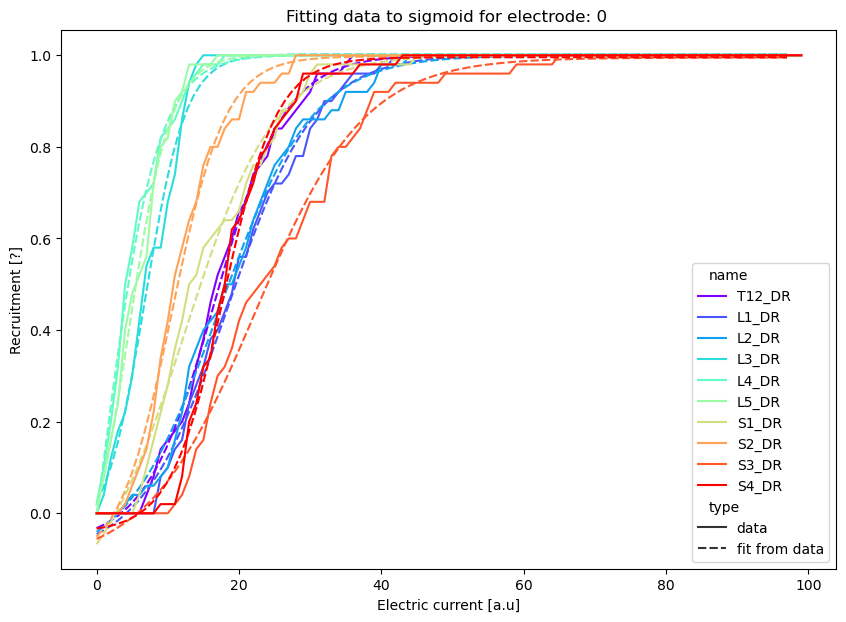

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_1_sigmoid_fit_MR012.png 


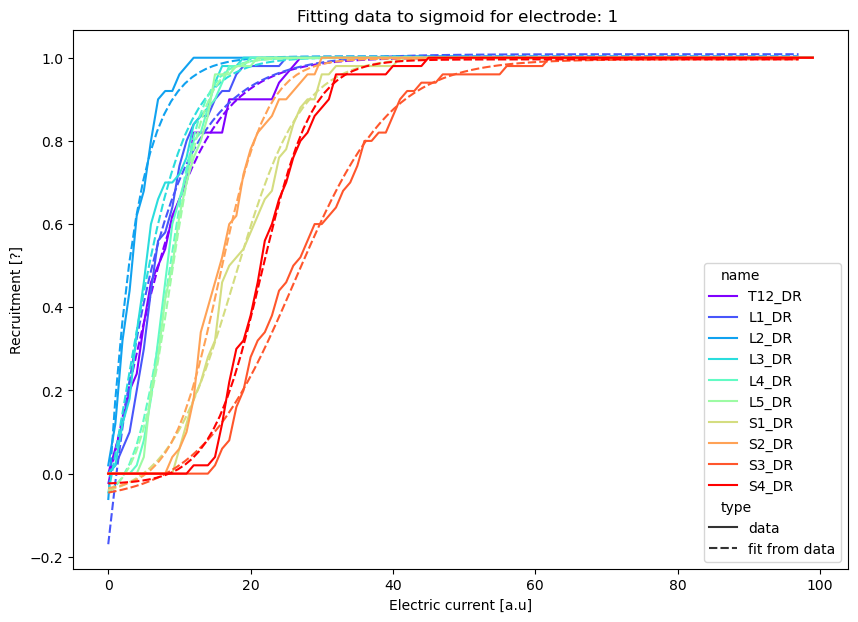

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_2_sigmoid_fit_MR012.png 


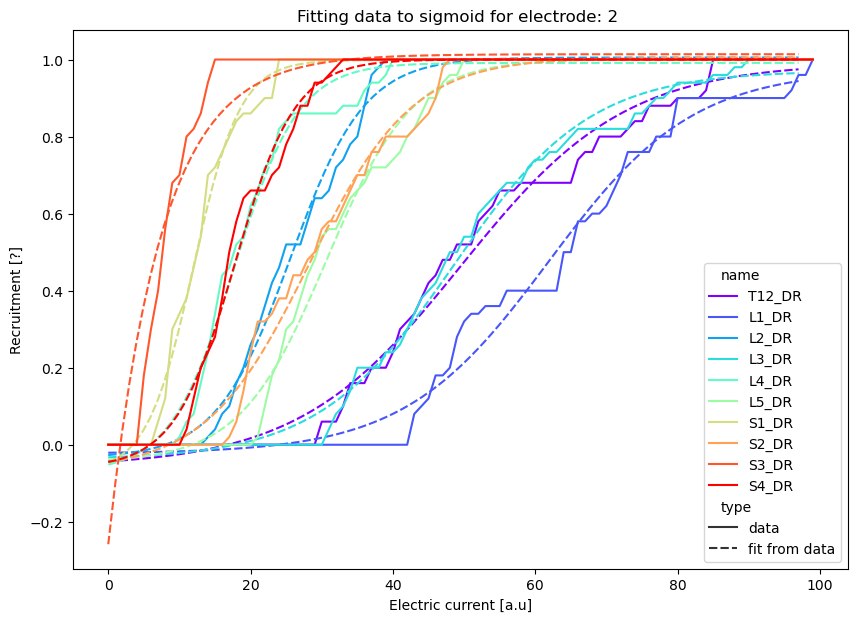

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_3_sigmoid_fit_MR012.png 


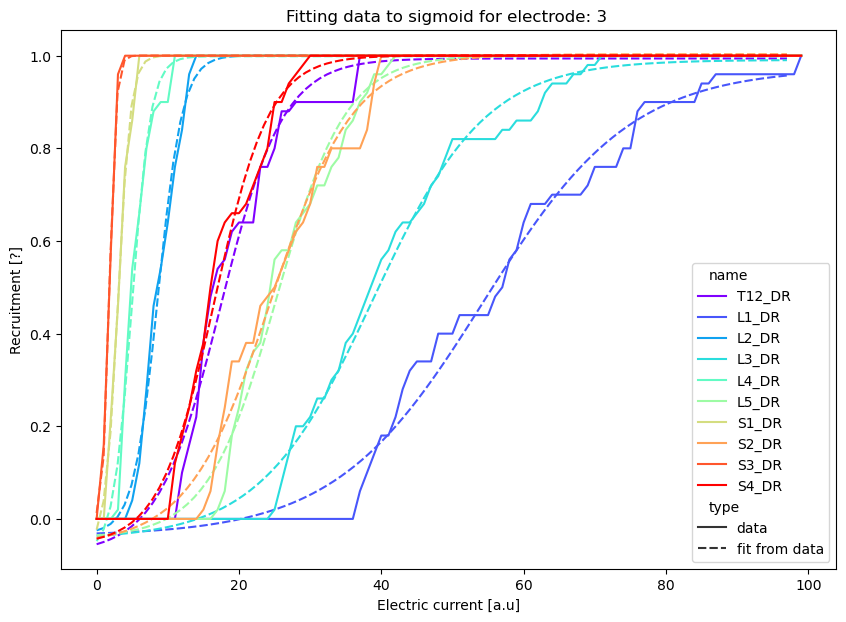

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_4_sigmoid_fit_MR012.png 


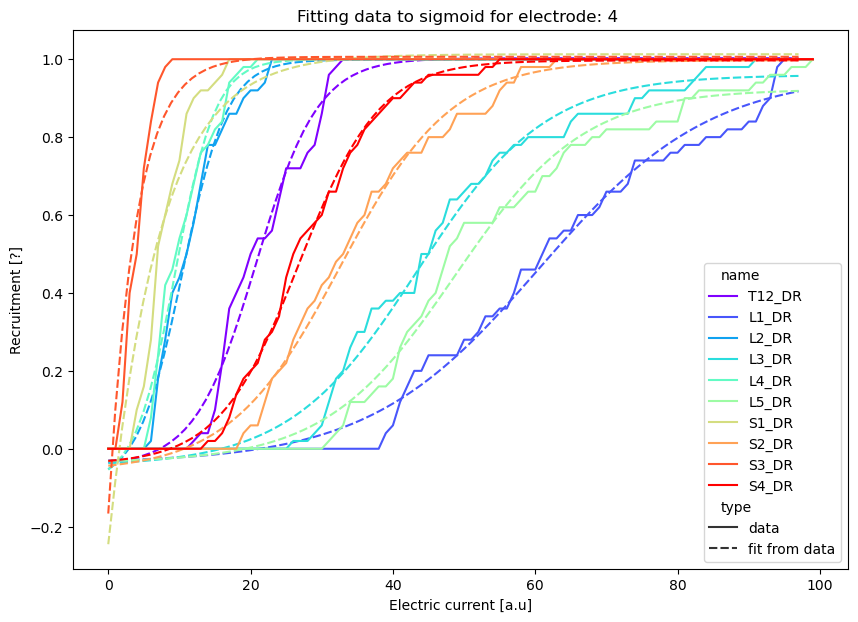

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_5_sigmoid_fit_MR012.png 


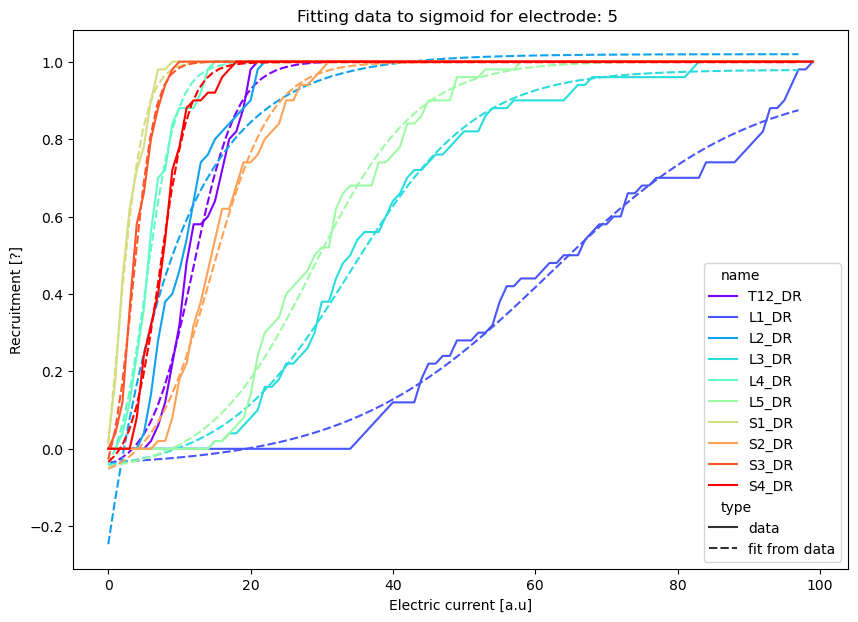

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_6_sigmoid_fit_MR012.png 


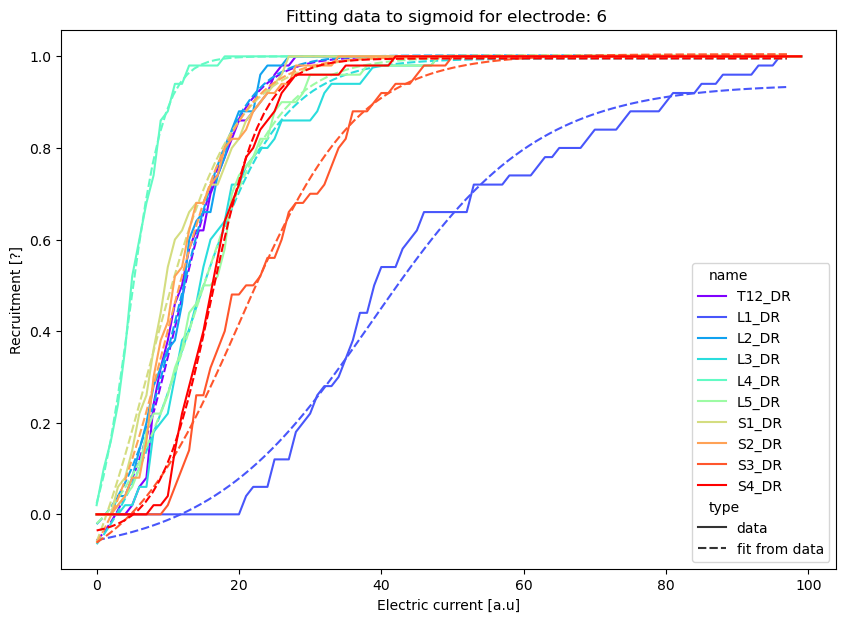

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_7_sigmoid_fit_MR012.png 


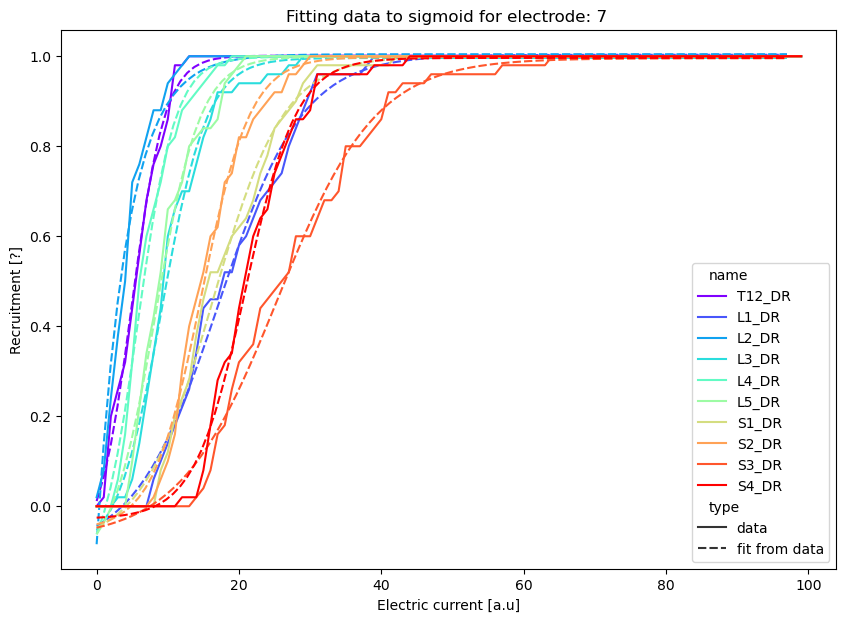

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_8_sigmoid_fit_MR012.png 


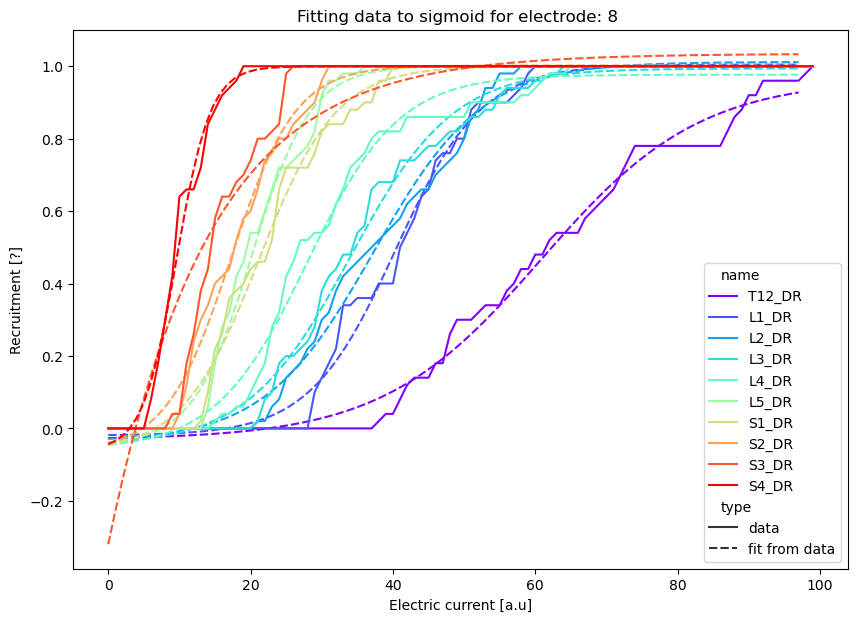

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_9_sigmoid_fit_MR012.png 


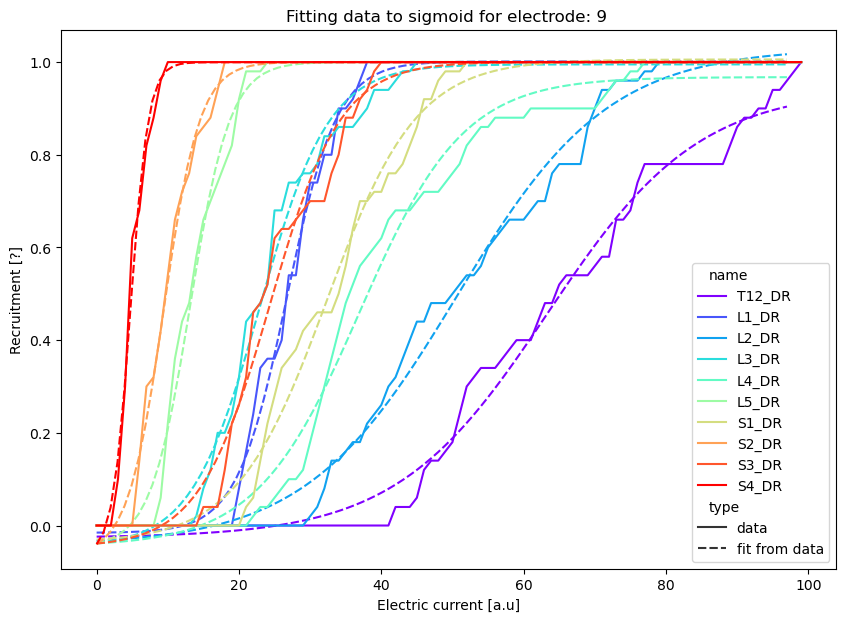

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_10_sigmoid_fit_MR012.png 


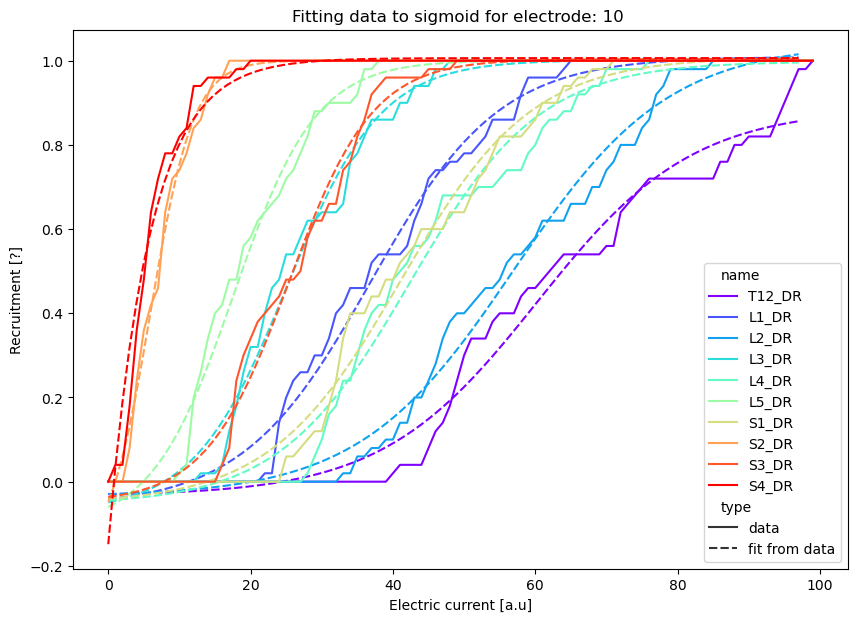

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_11_sigmoid_fit_MR012.png 


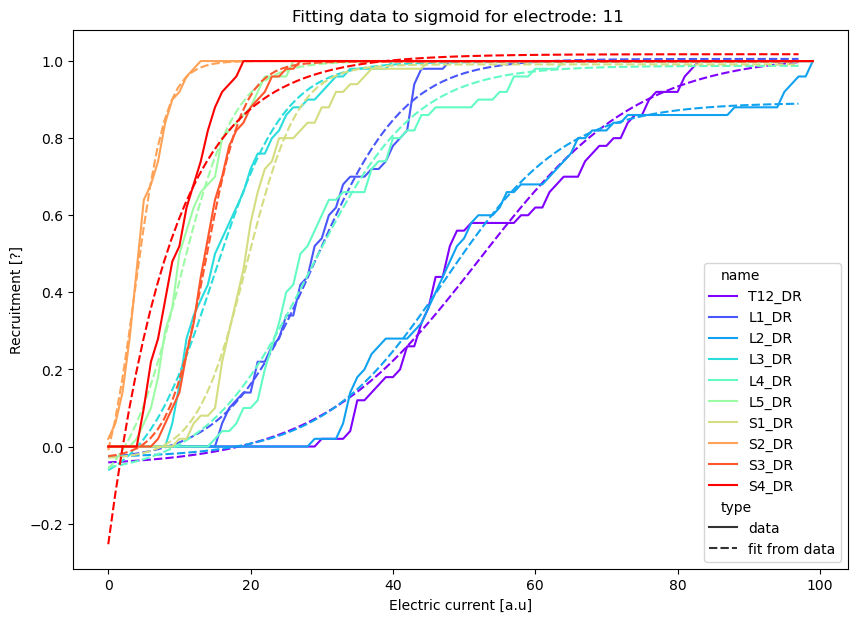

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_12_sigmoid_fit_MR012.png 


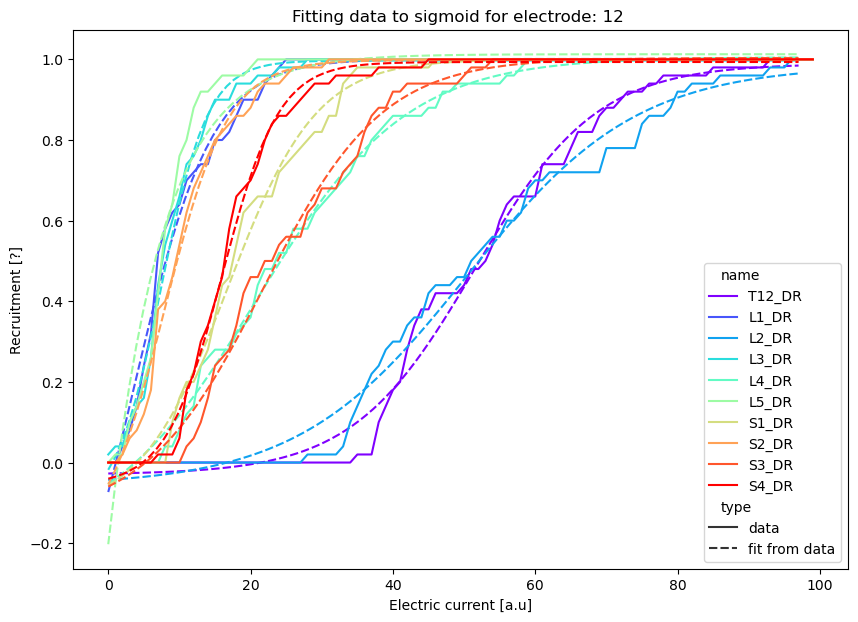

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_13_sigmoid_fit_MR012.png 


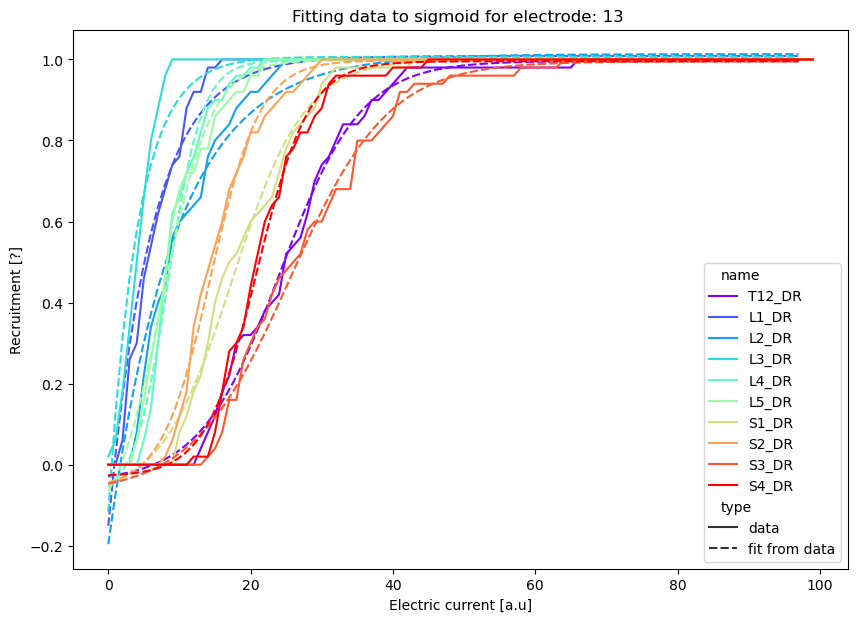

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_14_sigmoid_fit_MR012.png 


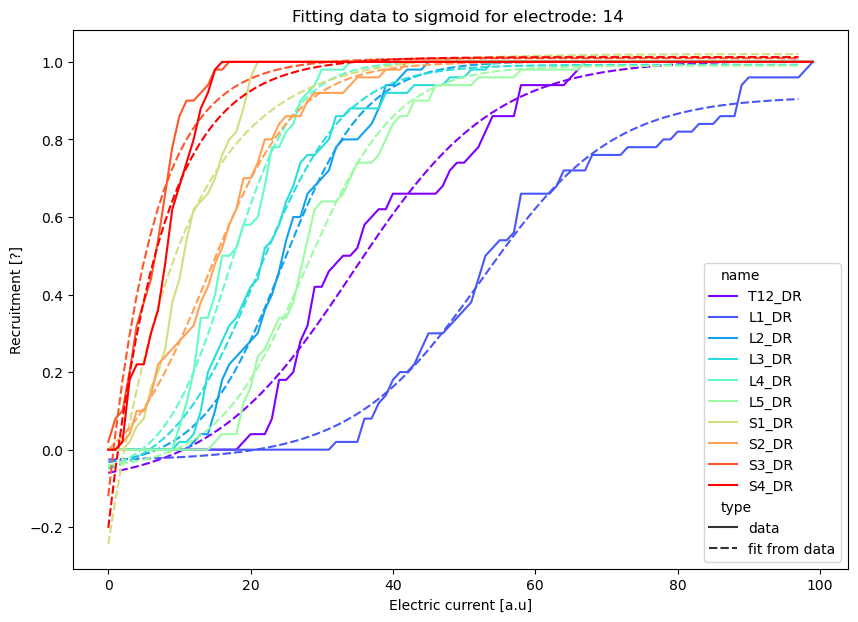

 figure saved: /Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/MR012/sigmoidal_fit/roots/elec_15_sigmoid_fit_MR012.png 


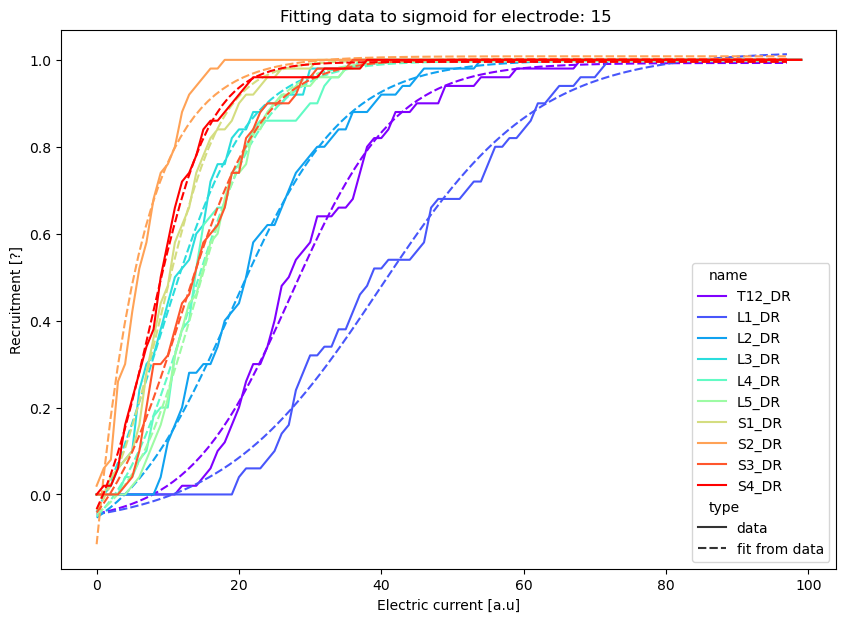

In [290]:
fit_sigmoid_max_value_given(root_side=0)

## Evaluation preparation

define which matrices to export for the evaluation

In [113]:
# between 0 and 1
matrix_roots_df=get_number_for_heat_map_100_electric_current_normalise_by_max_root_response()
matrix_roots_df.to_csv(location_data_dump+'matrix_roots_df.csv')

# # between 0 and 100
# matrix_roots=get_number_for_heat_map_100_electric_current()
# matrix_roots_df.to_csv('/Volumes/Extreme_SSD/Projectome_Estimation/evaluation_data/matrix_roots_df.csv')

## for simgoid curves get 
matrix_parameters_root_df=1
matrix_parameters_root_df.to_csv(location_data_dump+'matrix_parameters_root_df.csv')


normalisation method is: (100-electric_current)_normalise_by_max_root_response
